#Codice da eseguire preliminarmente

##Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer

In [3]:
df_sostanze = pd.read_csv('/content/drive/MyDrive/dataset_solo_sostanze.csv')
df_delhi = pd.read_csv('/content/drive/MyDrive/dataset_delhi_con_cond_atmosferiche.csv')

##Definizione di costanti e funzioni di utilità

In [4]:
#Colori
arancione = '#FF671F'
bianco = '#FFFFFF'
verde = '#046A38'
arancione_sfondo = "#FFA57A"
grigio = '#DDDDDD'
blu = '#06038D'
bordeaux = '#7d0005'
cluster_colors = [verde, blu, bordeaux, '#00b5c1', '#d900d1', bianco, '#00fe99']
bg_color = arancione_sfondo

In [5]:
#funzione che calcola la matrice di correlazione e mostra la heatmap
def mostra_heatmap_correlazione(dataframe, campi_da_correlare, metodo, titolo):

  matrice_correlazione = dataframe[campi_da_correlare].corr(method=metodo)

  # Definizione di una colormap personalizzata
  indian_cmap = LinearSegmentedColormap.from_list(
      'custom_cmap',
      [arancione, bianco, verde]  # Da arancione a bianco a verde (colori della bandiera indiana)
  )

  # Creazione della heatmap con scala personalizzata
  plt.figure(figsize=(8, 6))
  sns.heatmap(
      matrice_correlazione,
      annot=True,
      cmap=indian_cmap,  # Colormap personalizzata
      vmin=-1,           # Valore minimo della scala
      vmax=1,            # Valore massimo della scala
      fmt=".2f",
      cbar=True          # Mostra la barra dei colori
  )

  # Titolo per la heatmap
  plt.title(f'{titolo}')
  plt.show()

In [6]:
def correlazione_giorno_succ(dataframe, sostanza):

  # Creazione di colonne lag (valori del giorno precedente)
  dataframe[f'{sostanza} giorno succ.'] = dataframe[f'{sostanza}'].shift(-1)

  # Rimozione dei valori NaN introdotti dal lag
  df = dataframe.dropna()

  colonne_da_correlare=[f'{sostanza} giorno succ.', 'Ozone (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)',
                          'AT (degree C)','BP (mmHg)','RF (mm)','RH (%)', 'SR (W/mt2)', 'WD (deg)', 'WS (m/s)']

  mostra_heatmap_correlazione(dataframe, colonne_da_correlare, 'pearson', f'Matrice di Correlazione di Pearson per {sostanza}')


In [7]:
def correlazione_con_lag_per_condizione(dataframe, condizione_da_analizzare, lista_lag):

  # Creazione di colonne lag (valori degli istanti precedenti)
  for i in lista_lag:
    dataframe[f'{condizione_da_analizzare} -{i}'] = dataframe[f'{condizione_da_analizzare}'].shift(i)

  # Rimozione dei valori NaN introdotti dal lag
  df = dataframe.dropna()

  colonne_da_correlare=['Ozone (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)',
                          f'{condizione_da_analizzare}']

  # Aggiunta dinamica delle colonne lag
  colonne_da_correlare += [f'{condizione_da_analizzare} -{i}' for i in lista_lag]

  mostra_heatmap_correlazione(dataframe, colonne_da_correlare, 'pearson', f'Matrice di Correlazione di Pearson per {condizione_da_analizzare}')
  mostra_heatmap_correlazione(dataframe, colonne_da_correlare, 'spearman', f'Matrice di Correlazione di Spearman per {condizione_da_analizzare}')

In [8]:
def correlazione_con_lag_per_sostanza(dataframe, sostanza_da_analizzare, lista_lag):

  # Creazione di colonne lag (valori degli istanti successivi)
  for i in lista_lag:
    dataframe[f'{sostanza_da_analizzare} +{i}'] = dataframe[f'{sostanza_da_analizzare}'].shift(-i)

  # Rimozione dei valori NaN introdotti dal lag
  df = dataframe.dropna()

  colonne_da_correlare=[sostanza_da_analizzare]
  colonne_da_correlare += [f'{sostanza_da_analizzare} +{i}' for i in lista_lag]
  colonne_da_correlare += ['AT (degree C)','BP (mmHg)','RF (mm)','RH (%)', 'SR (W/mt2)', 'WD (deg)', 'WS (m/s)']

  mostra_heatmap_correlazione(dataframe, colonne_da_correlare, 'pearson', f'Matrice di Correlazione di Pearson per {sostanza_da_analizzare}')
  mostra_heatmap_correlazione(dataframe, colonne_da_correlare, 'spearman', f'Matrice di Correlazione di Spearman per {sostanza_da_analizzare}')


In [9]:
# Elbow Method con colori personalizzati
def elbow_method(data, max_k=10, bg_color=arancione_sfondo, line_color=verde):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    ax = plt.gca()              # Ottiene gli assi correnti
    ax.set_facecolor(bg_color)  # Imposta il colore dello sfondo
    plt.plot(range(1, max_k + 1), inertias, marker='o', color=line_color)
    plt.title('Elbow Method', fontsize=14)
    plt.xlabel('Numero di cluster (k)', fontsize=12)
    plt.ylabel('Inerzia', fontsize=12)
    plt.grid(True, color=grigio)
    plt.show()

    return inertias


# Applica K-Means
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return kmeans, labels

#Visualizza i cluster e stampa il silhouette score
def plot_silhouette(data, labels, x_label="Variazione della concentrazione tra 2021 e 2022", y_label="Concentrazione nel 2022"):
    # Calcolo del Silhouette Score
    score = silhouette_score(data, labels)
    print(f'Silhouette Score: {score:.2f}')

    # Associazione di colori ai cluster
    unique_labels = sorted(set(labels))
    cluster_names = [f"Cluster {i}" for i in unique_labels]

    # Mappatura dei cluster ai colori
    color_mapping = {label: cluster_colors[i] for i, label in enumerate(unique_labels)}
    cluster_labels = {label: name for label, name in zip(unique_labels, cluster_names)}

    # Visualizzazione
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_facecolor(bg_color)
    for label in unique_labels:
        plt.scatter(
            data.iloc[labels == label, 0],  # Filtra i punti per cluster
            data.iloc[labels == label, 1],
            color=color_mapping[label],
            label=cluster_labels[label],
            s=50,
            alpha=0.7
        )

    plt.title('Risultato del clustering con K-Means', fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(title="Legenda", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.grid(True, color=grigio)
    plt.show()

def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return dbscan, labels

def plot_clusters(data, labels, title, x_label="Variazione della concentrazione tra 2021 e 2022", y_label="Concentrazione nel 2022"):
    plt.figure(figsize=(8, 6))

    # Associa colori ai cluster
    unique_labels = sorted(set(labels))
    cluster_names = [f"Cluster {i}" for i in unique_labels]

    # Mappatura dei cluster ai colori
    color_mapping = {label: cluster_colors[i] for i, label in enumerate(unique_labels)}
    cluster_labels = {label: name for label, name in zip(unique_labels, cluster_names)}
    ax = plt.gca()
    ax.set_facecolor(bg_color)

    # Visualizzazione dei punti per cluster
    for label in unique_labels:
        plt.scatter(
            data.iloc[labels == label, 0],  # Filtra i punti per il cluster
            data.iloc[labels == label, 1],
            color=color_mapping[label],
            label=cluster_labels[label],
            s=50,
            alpha=0.7
        )

    # Configurazione del grafico
    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(title="Legenda", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.grid(True, color=grigio)
    plt.show()

def apply_agglomerative(data, n_clusters=3, linkage_method='ward'):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    labels = agglomerative.fit_predict(data)
    return agglomerative, labels

def find_eps(data, min_samples, bg_color=arancione_sfondo, line_color=verde):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, -1])  # Distanza dal vicino più lontano per ogni punto
    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.set_facecolor(bg_color)
    plt.plot(distances, color=line_color)
    plt.title("Grafico delle distanze ordinate", fontsize=14)
    plt.xlabel("Punti ordinati", fontsize=12)
    plt.ylabel("Distanza del vicino più lontano", fontsize=12)
    plt.grid(True, color=grigio)
    plt.show()


In [10]:
def silhouette_plot(data, labels, cluster_colors=None, bg_color="white", grid_color="lightgrey", avg_line_color="red"):
    # Calcolo del silhouette score e i valori individuali
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)

    # Impostazione dei cluster univoci e i colori
    unique_labels = sorted(set(labels))
    cluster_colors = cluster_colors[:len(unique_labels)]

    # Creazione del grafico
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_facecolor(bg_color)

    y_lower = 10
    for i, label in enumerate(unique_labels):
        # Filtraggio dei valori di silhouette per il cluster corrente
        cluster_silhouette_values = sample_silhouette_values[labels == label]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        y_upper = y_lower + cluster_size

        # Tracciamento della silhouette per il cluster corrente
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values,
            facecolor=cluster_colors[i],
            edgecolor=cluster_colors[i],
            alpha=0.7,
        )
        plt.text(-0.09, y_lower + 0.5 * cluster_size, f"Cluster {label}", fontsize=10, color=cluster_colors[i])
        y_lower = y_upper + 10  # Spaziatura tra i cluster

    # Disegna la linea dell'average silhouette score
    plt.axvline(x=silhouette_avg, color=avg_line_color, linestyle="--", linewidth=2, label="Average Silhouette Score")
    x_max = max(sample_silhouette_values) + 0.1
    plt.xlim([-0.1, x_max])  # Lo zero è spostato a destra con un margine negativo

    # Configurazioni del grafico
    plt.title("Silhouette Analysis", fontsize=14)
    plt.xlabel("Silhouette Coefficient Values", fontsize=12)
    plt.ylabel("Cluster", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(color=grid_color, linestyle="--", linewidth=0.5)  # Griglia personalizzata
    plt.show()


#Correlazioni

##Correlazioni tra sostanze

Correlazioni tra le concentrazioni di sostanze rilevate da tutte le stazioni presenti nel dataset

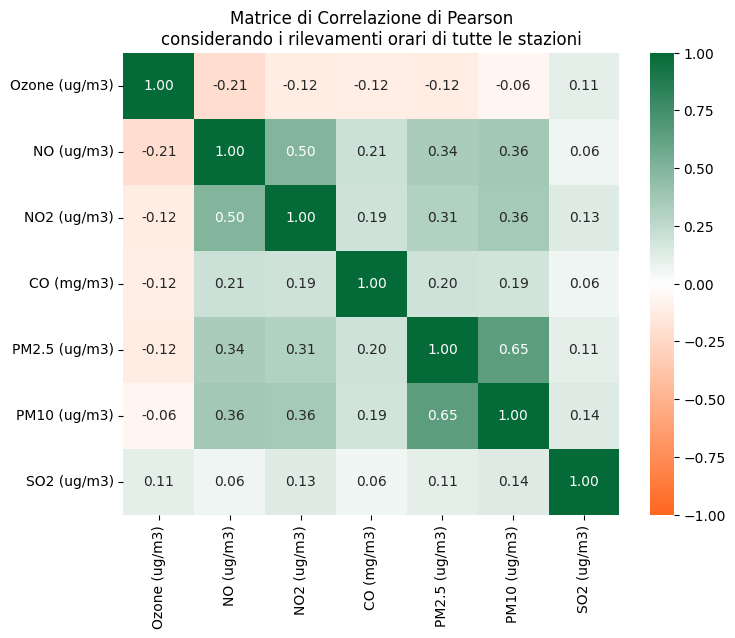

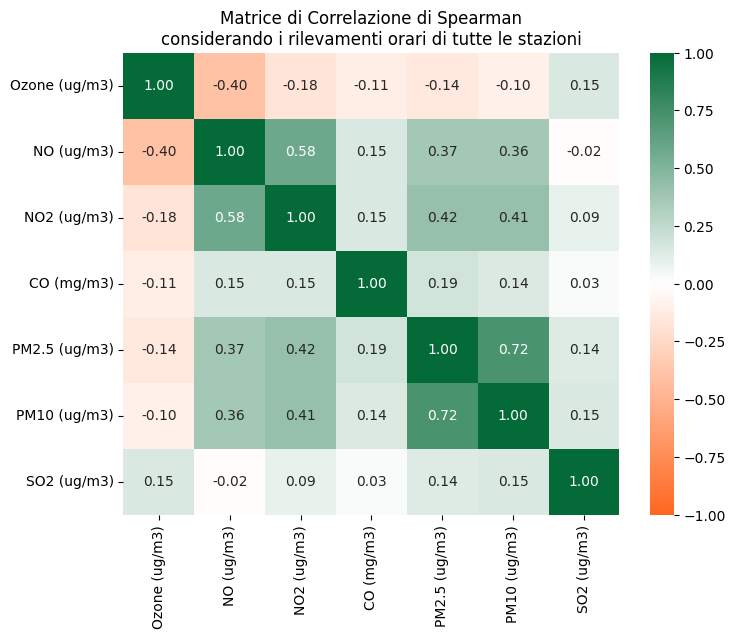

In [ ]:
# Selezione delle colonne per il calcolo della correlazione
colonne_da_correlare = ['Ozone (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)']

mostra_heatmap_correlazione(df_sostanze, colonne_da_correlare, 'pearson', 'Matrice di Correlazione di Pearson\nconsiderando i rilevamenti orari di tutte le stazioni')
mostra_heatmap_correlazione(df_sostanze, colonne_da_correlare, 'spearman', 'Matrice di Correlazione di Spearman\nconsiderando i rilevamenti orari di tutte le stazioni')

Si può notare la presenza di:

*   una forte correlazione lineare positiva tra PM2.5 e PM10
*   una correlazione lineare positiva tra NO e NO2 (ossidi di azoto)
*   una lieve correlazione positiva tra il particolato e gli ossidi di azoto (PM2.5, PM10, NO, NO2)
*   una lieve correlazione negativa tra NO e Ozono, che però non è lineare data la rilevante differenza tra coefficiente di Sperman e coefficiente di Pearson



Correlazioni durante il giorno e durante la notte

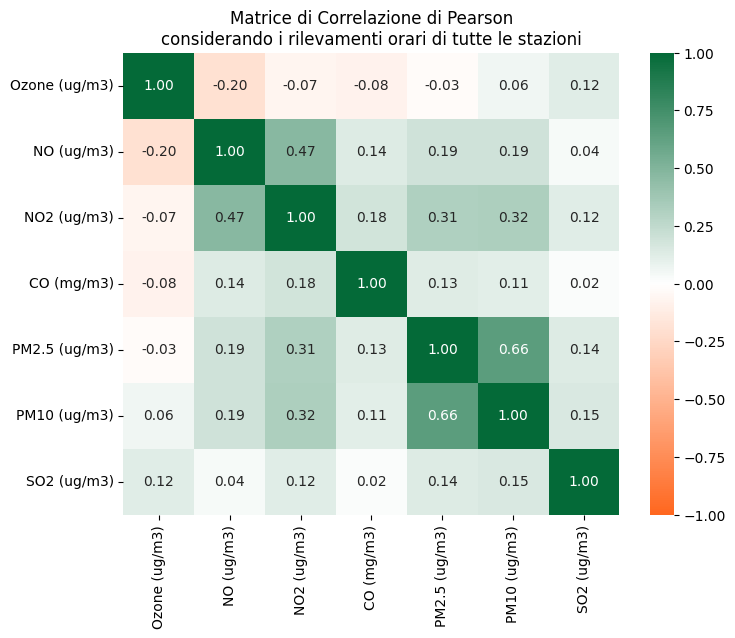

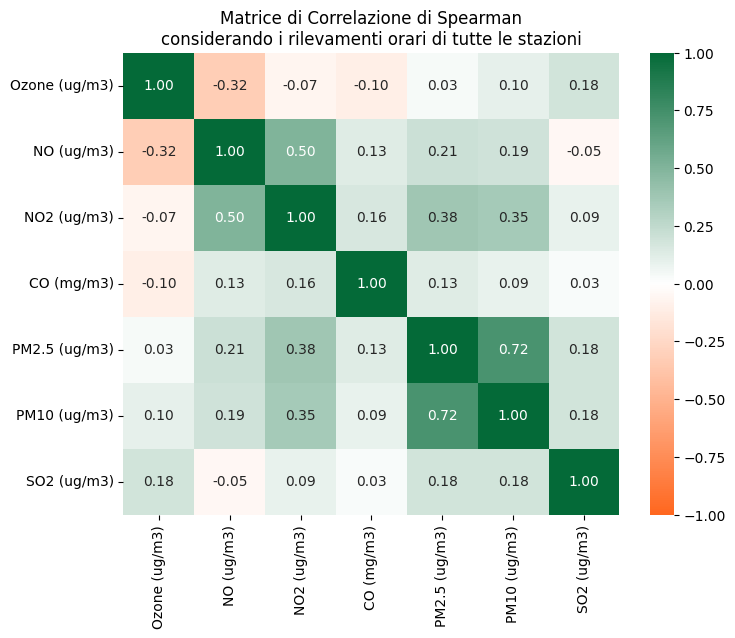

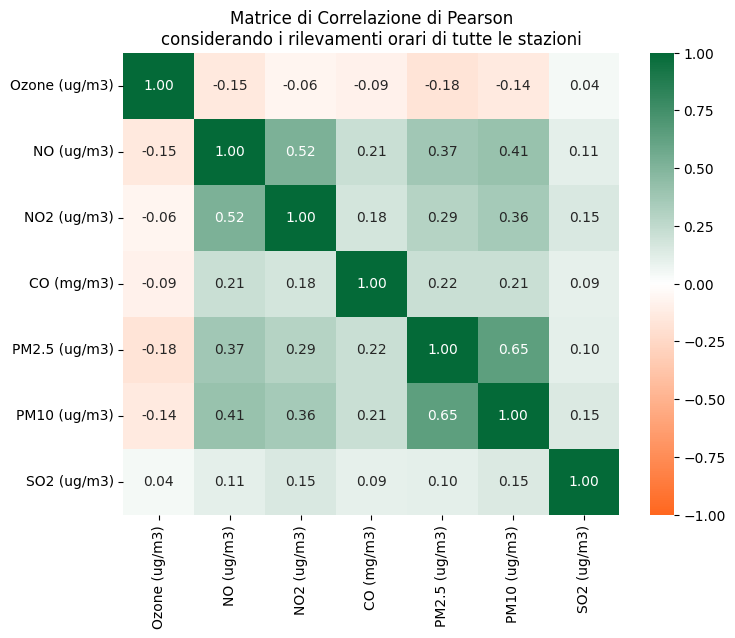

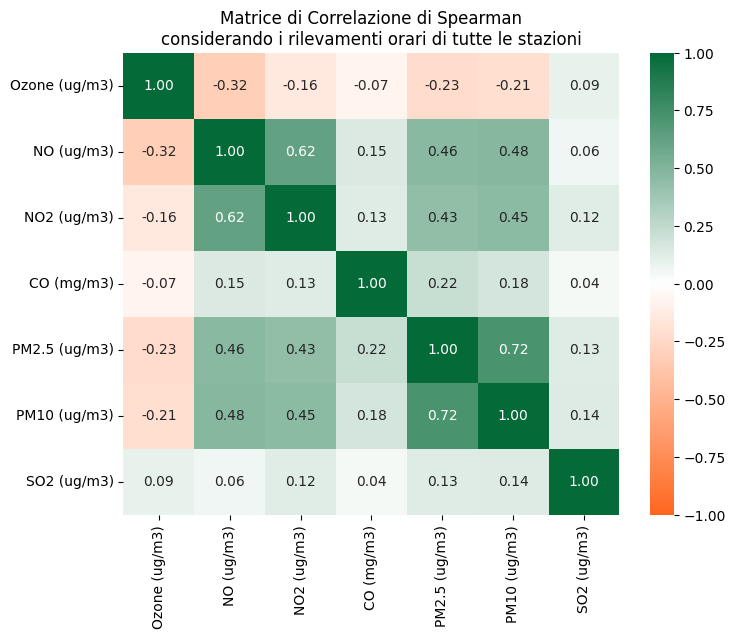

In [ ]:
df_sostanze['From Date'] = pd.to_datetime(df_sostanze['From Date'])

df_sostanze_giorno = df_sostanze[(df_sostanze['From Date'].dt.hour >= 8) & (df_sostanze['From Date'].dt.hour <= 18)]
df_sostanze_notte = df_sostanze[(df_sostanze['From Date'].dt.hour <= 7) | (df_sostanze['From Date'].dt.hour >= 19)]

mostra_heatmap_correlazione(df_sostanze_giorno, colonne_da_correlare, 'pearson', 'Matrice di Correlazione di Pearson\nconsiderando i rilevamenti orari di tutte le stazioni')
mostra_heatmap_correlazione(df_sostanze_giorno, colonne_da_correlare, 'spearman', 'Matrice di Correlazione di Spearman\nconsiderando i rilevamenti orari di tutte le stazioni')

mostra_heatmap_correlazione(df_sostanze_notte, colonne_da_correlare, 'pearson', 'Matrice di Correlazione di Pearson\nconsiderando i rilevamenti orari di tutte le stazioni')
mostra_heatmap_correlazione(df_sostanze_notte, colonne_da_correlare, 'spearman', 'Matrice di Correlazione di Spearman\nconsiderando i rilevamenti orari di tutte le stazioni')

Scatter plot

In [ ]:
# Pairplot
sns.pairplot(df_sostanze[['Ozone (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)']])
plt.show()

##Correlazioni tra condizioni atmosferiche e sostanze (solo per Delhi)

###Correlazione tra il valore orario delle sostanze e delle condizioni atmosferiche

In [ ]:
# Calcolo delle componenti del vento
df_delhi['wind_E-O'] = df_delhi['WS (m/s)'] * np.cos(np.radians(df_delhi['WD (deg)']))
df_delhi['wind_N-S'] = df_delhi['WS (m/s)'] * np.sin(np.radians(df_delhi['WD (deg)']))

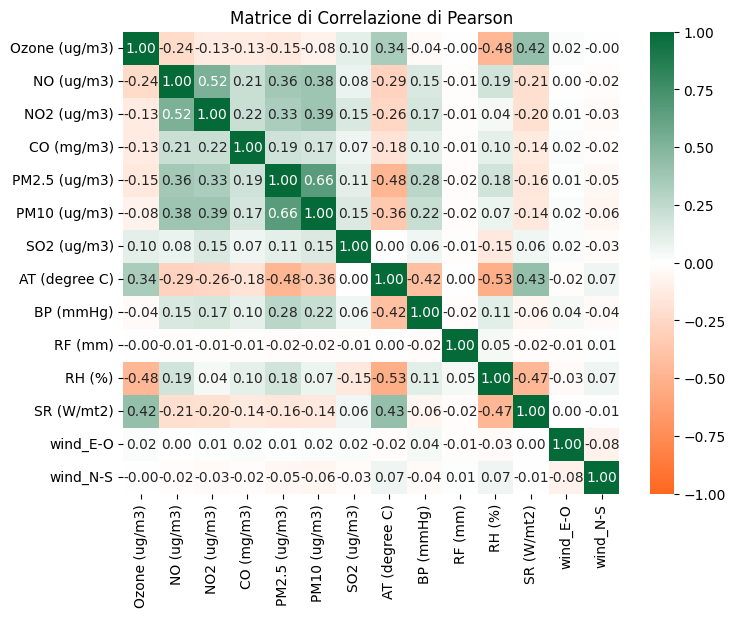

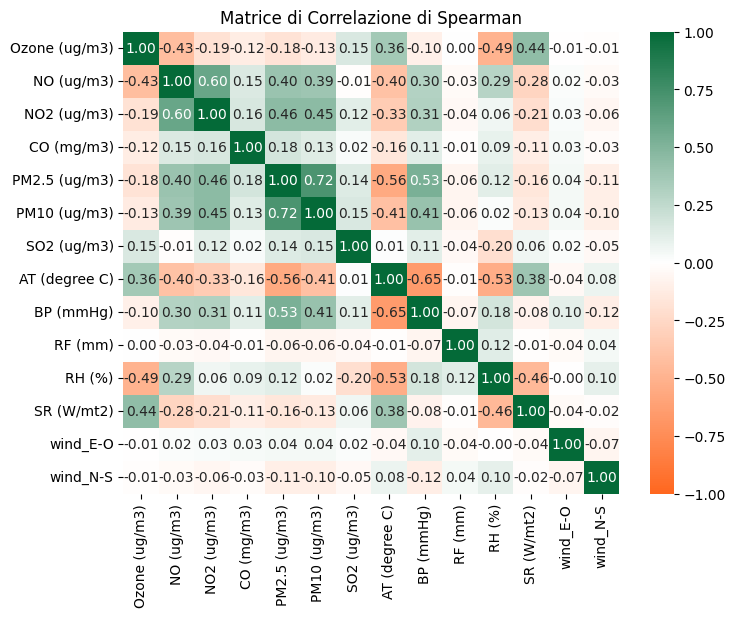

In [ ]:
# Selezione delle colonne per il calcolo della correlazione
colonne_da_correlare = ['Ozone (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'CO (mg/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)',
                        'AT (degree C)','BP (mmHg)','RF (mm)','RH (%)', 'SR (W/mt2)', 'wind_E-O', 'wind_N-S']

mostra_heatmap_correlazione(df_delhi, colonne_da_correlare, 'pearson', 'Matrice di Correlazione di Pearson\nconsiderando i rilevamenti orari delle stazioni di Delhi')
mostra_heatmap_correlazione(df_delhi, colonne_da_correlare, 'spearman', 'Matrice di Correlazione di Spearman\nconsiderando i rilevamenti orari delle stazioni di Delhi')

Si può notare che:

- le correlazioni tra le concentrazioni delle diverse sostanze sono in linea con quelle emerse nell'analisi delle correlazioni di tutte le città (anche se un po' attenuate)
- la temperatura dell'aria è la condizione atmosferica che ha correlazioni (sia positive che negative) più forti con la concentrazione delle sostanze. In particolare, i particolati (PM2.5 e PM10) e gli ossidi di azoto (NO e NO2) aumentano al diminuire della temperatura, mentre l'ozono (O3) è correlato positivamente alla temperatura. Quest'ultimo risultato deriva probabilmente dal fatto che la concentrazione di Ozono dipende dalle radiazioni solari (SR), che a loro volta sono correlate alla temperatura, con cui la dipendenza è invece indiretta.
- un'altra condizione atmosferica che mostra correlazioni dirette significative con le concentrazioni di diverse sostanze è la pressione atmosferica, che è correlata negativamente alla temperatura


###Correlazioni con lag

In [ ]:
df_dl_station = df_delhi[df_delhi['file_name'].str.startswith('DL023')]
# Impostazione della colonna From Data come indice
df_dl_station.set_index('From Date', inplace=True)

In [ ]:
for condizione_atmosferica in ['AT (degree C)','BP (mmHg)','RF (mm)','RH (%)', 'SR (W/mt2)', 'WD (deg)', 'WS (m/s)']:
  correlazione_con_lag_per_condizione(df_dl_station, condizione_atmosferica, [1,2,6,12,18,24,48])

Output hidden; open in https://colab.research.google.com to view.

#Clustering
Analisi delle città sulla base del livello di inquinamento del 2022 e della variazione del livello di inquinamento tra 2021 e 2022

##ETL

Selezione delle stazioni che hanno iniziato a misurare da prima del 1/1/2021

In [11]:
df_sostanze_filtrato = df_sostanze[df_sostanze['start_year'] < 2021]

Selezione delle sole misurazioni effettuate nel 2021 o nel 2022

In [12]:
df_sostanze_filtrato['From Date'] = pd.to_datetime(df_sostanze_filtrato['From Date'])
df_sostanze_filtrato = df_sostanze_filtrato[
    (df_sostanze_filtrato['From Date'].dt.year >= 2021) &
    (df_sostanze_filtrato['From Date'].dt.year <= 2022)
]

<ipython-input-12-5c12d28741ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sostanze_filtrato['From Date'] = pd.to_datetime(df_sostanze_filtrato['From Date'])


Aggregazione dei record per città ed anno usando la media come funzione di aggregazione. Dunque, ora ogni riga contiene la concentrazione media su base annuale di ogni sostanza per una città.

In [13]:
campi_da_mantenere = ['city', 'From Date', 'Ozone (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
                  'CO (mg/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)']

# Selezione delle colonne di interesse
df_sostanze_filtrato = df_sostanze_filtrato[campi_da_mantenere]

# Aggiunta di una colonna "Year" al dataframe
df_sostanze_filtrato['Year'] = df_sostanze_filtrato['From Date'].dt.year

# Raggruppamento per "Year" e "city"
df_sostanze_aggregato = df_sostanze_filtrato.groupby(['Year', 'city']).agg({
    'Ozone (ug/m3)': 'mean',
    'NO (ug/m3)': 'mean',
    'NO2 (ug/m3)': 'mean',
    'CO (mg/m3)': 'mean',
    'PM2.5 (ug/m3)': 'mean',
    'PM10 (ug/m3)': 'mean',
    'SO2 (ug/m3)': 'mean',
}).reset_index()

Creazione di un nuovo dataframe funzionale al clustering. Esso avrà come campi quelli che esprimono la città e, per ogni sostanza, la sua concentrazione media nel 2022 e la differenza tra concentrazione media tra 2022 e 2021.

In [14]:
df_sostanze_aggregato_2021 = df_sostanze_aggregato[df_sostanze_aggregato['Year'] == 2021].set_index('city').drop(columns=['Year'])
df_sostanze_aggregato_2022 = df_sostanze_aggregato[df_sostanze_aggregato['Year'] == 2022].set_index('city').drop(columns=['Year'])

# Calcolo delle differenze tra il 2022 e il 2021
df_sostanze_aggregato_diff = (df_sostanze_aggregato_2022 - df_sostanze_aggregato_2021).add_suffix(' diff (2022-2021)')

# Rinominazione delle colonne per indicare i valori dell'anno 2022
df_sostanze_aggregato_2022 = df_sostanze_aggregato_2022.add_suffix(' (2022)')

# Combinazione dei dati in un unico dataframe
result = pd.concat([df_sostanze_aggregato_2022, df_sostanze_aggregato_diff], axis=1).reset_index()

print(result.columns)

Index(['city', 'Ozone (ug/m3) (2022)', 'NO (ug/m3) (2022)',
       'NO2 (ug/m3) (2022)', 'CO (mg/m3) (2022)', 'PM2.5 (ug/m3) (2022)',
       'PM10 (ug/m3) (2022)', 'SO2 (ug/m3) (2022)',
       'Ozone (ug/m3) diff (2022-2021)', 'NO (ug/m3) diff (2022-2021)',
       'NO2 (ug/m3) diff (2022-2021)', 'CO (mg/m3) diff (2022-2021)',
       'PM2.5 (ug/m3) diff (2022-2021)', 'PM10 (ug/m3) diff (2022-2021)',
       'SO2 (ug/m3) diff (2022-2021)'],
      dtype='object')


##Plotting dei dati

In [ ]:
def scatter_plot_substance(df, substance, x_lim=None, y_lim=None):
    """
    Crea un grafico a dispersione per una sostanza specifica.

    Parametri:
        df (pd.DataFrame): Il dataframe con i dati elaborati (contenente sia i valori per il 2022 che le differenze).
        substance (str): La sostanza da visualizzare (es. 'Ozone (ug/m3)').
    """
    # Creazione dei nomi delle colonne per il 2022 e la differenza
    col_2022 = f"{substance} (2022)"
    col_diff = f"{substance} diff (2022-2021)"

    # Verifica che le colonne esistano
    if col_2022 not in df.columns or col_diff not in df.columns:
        print(f"Errore: Colonne per '{substance}' non trovate nel dataframe.")
        return

    # Estrazione dei dati necessari
    x = df[col_diff]
    y = df[col_2022]
    cities = df['city']

    # Creazione del grafico
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color=arancione, alpha=0.7, edgecolor=verde)

    # Aggiunta di annotazioni con i nomi delle città
    for i, city in enumerate(cities):
        plt.text(x[i], y[i], city, fontsize=7, ha='right')

    # Configurazione del grafico
    plt.title(f"Scatter Plot: {substance} (2022 vs Diff 2022-2021)", fontsize=14)
    plt.xlabel(f"Diff {substance} (2022-2021)", fontsize=12)
    plt.ylabel(f"{substance} (2022)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.axhline(0, color=verde, linestyle='--', linewidth=0.8)
    plt.axvline(0, color=verde, linestyle='--', linewidth=0.8)

    # Applicazione di limiti degli assi
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)


    plt.show()

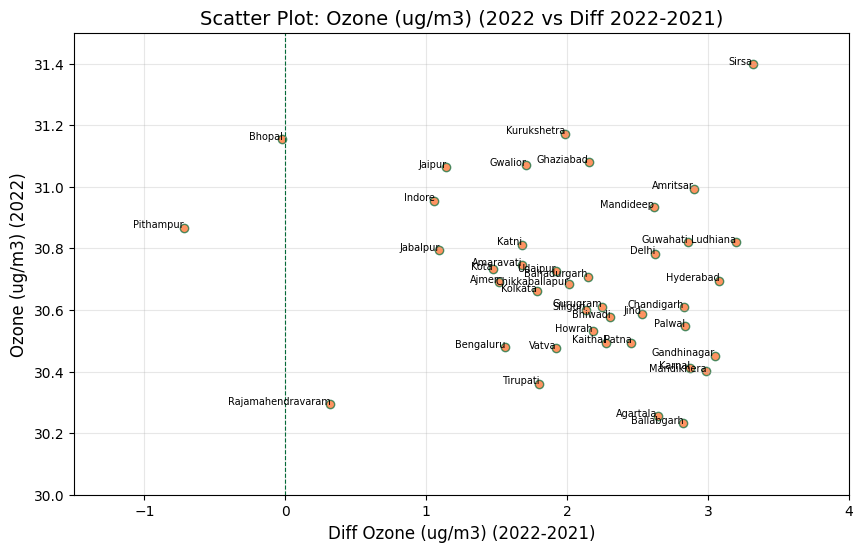

In [ ]:
scatter_plot_substance(result, 'Ozone (ug/m3)', x_lim=(-1.5, 4), y_lim=(30, 31.5))

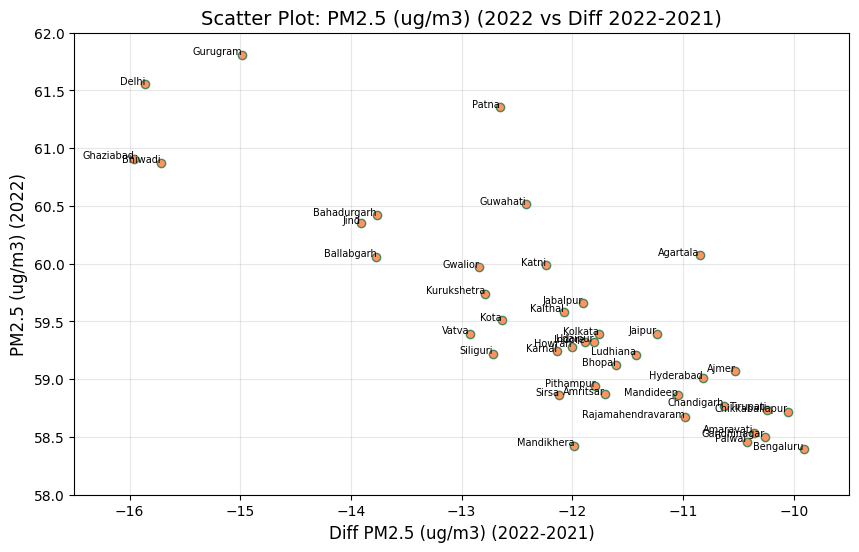

In [ ]:
scatter_plot_substance(result, 'PM2.5 (ug/m3)', x_lim=(-16.5, -9.5), y_lim=(58, 62))

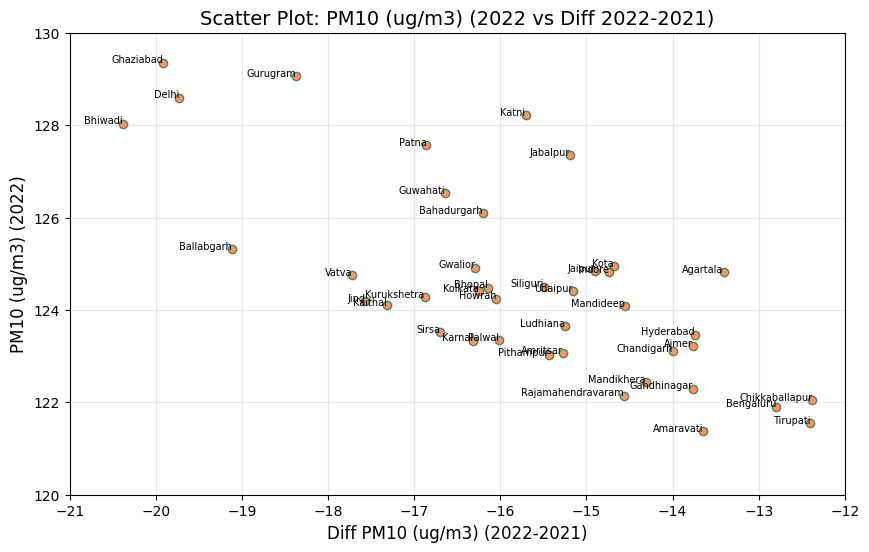

In [ ]:
scatter_plot_substance(result, 'PM10 (ug/m3)', x_lim=(-21, -12), y_lim=(120, 130))

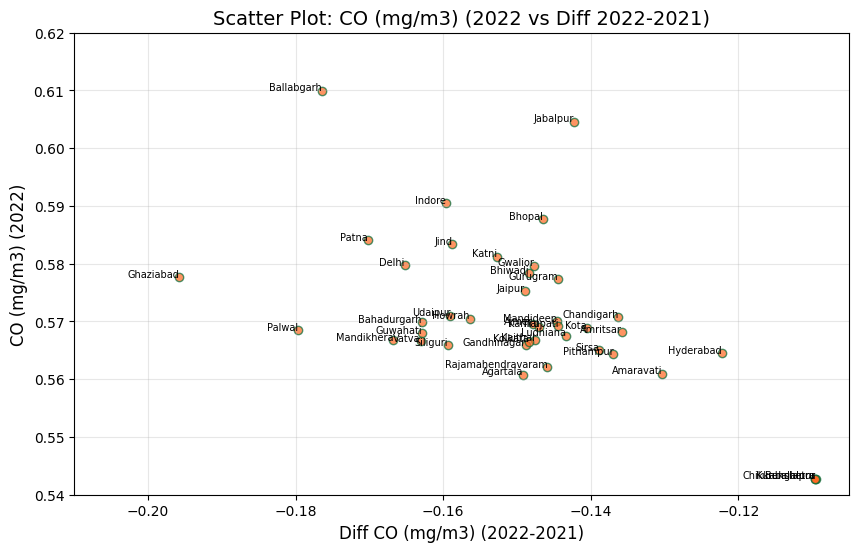

In [ ]:
scatter_plot_substance(result, 'CO (mg/m3)', x_lim=(-0.21, -0.105), y_lim=(0.54, 0.62))

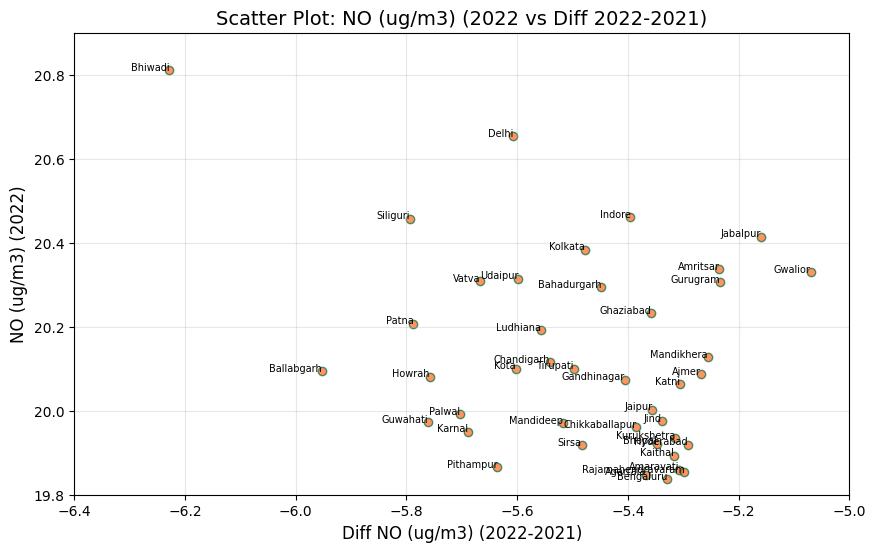

In [ ]:
scatter_plot_substance(result, 'NO (ug/m3)', x_lim=(-6.4, -5), y_lim=(19.8, 20.9))

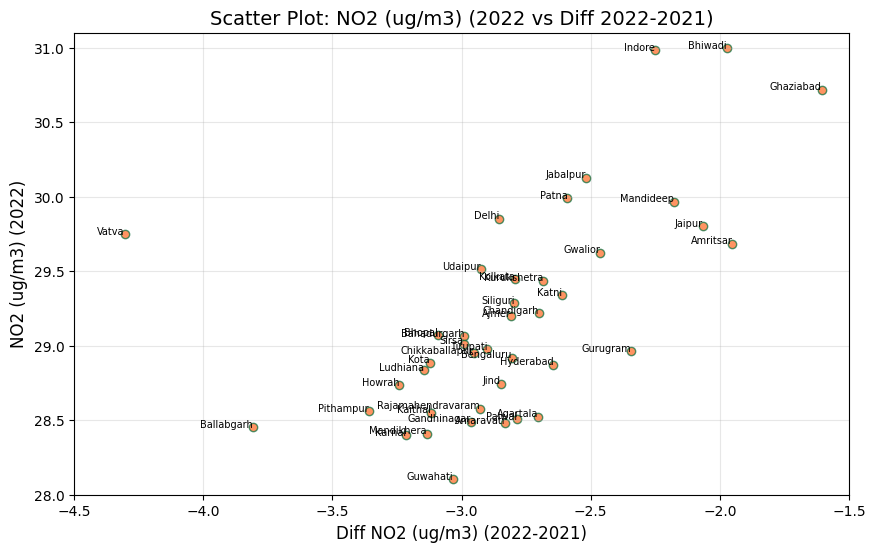

In [ ]:
scatter_plot_substance(result, 'NO2 (ug/m3)', x_lim=(-4.5, -1.5), y_lim=(28, 31.1))

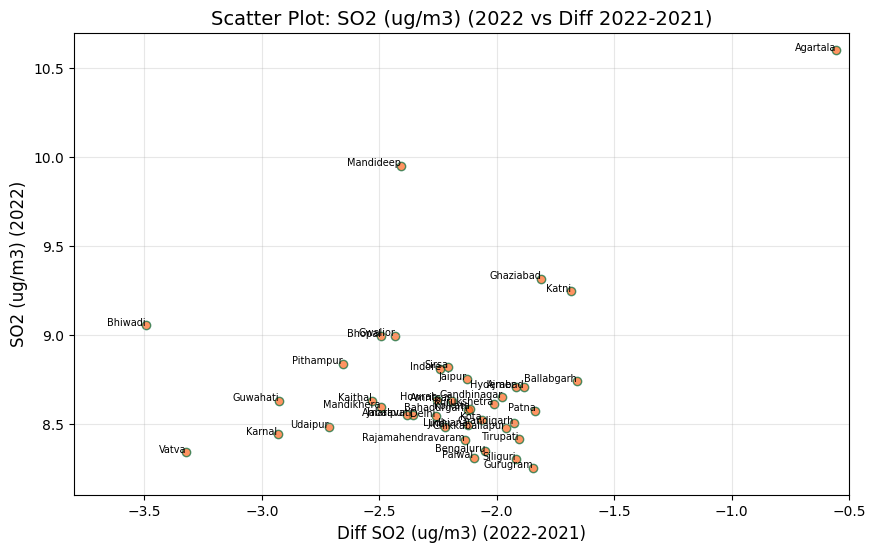

In [ ]:
scatter_plot_substance(result, 'SO2 (ug/m3)', x_lim=(-3.8, -0.5), y_lim=(8.1, 10.7))

##Clustering PM2.5

Selezione delle solo colonne di interesse per questo clustering

In [ ]:
df_clust_pm25 = result[['PM2.5 (ug/m3) diff (2022-2021)', 'PM2.5 (ug/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

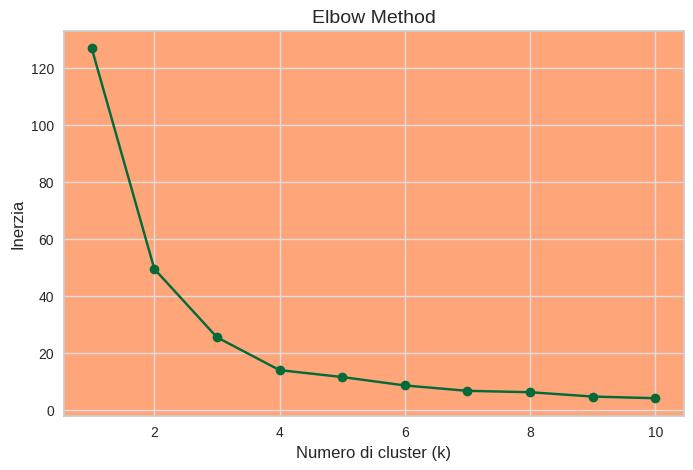

In [ ]:
inertias = elbow_method(df_clust_pm25, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 4
kmeans_model, labels = apply_kmeans(df_clust_pm25, n_clusters=optimal_k)
result['Cluster_pm25'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.48


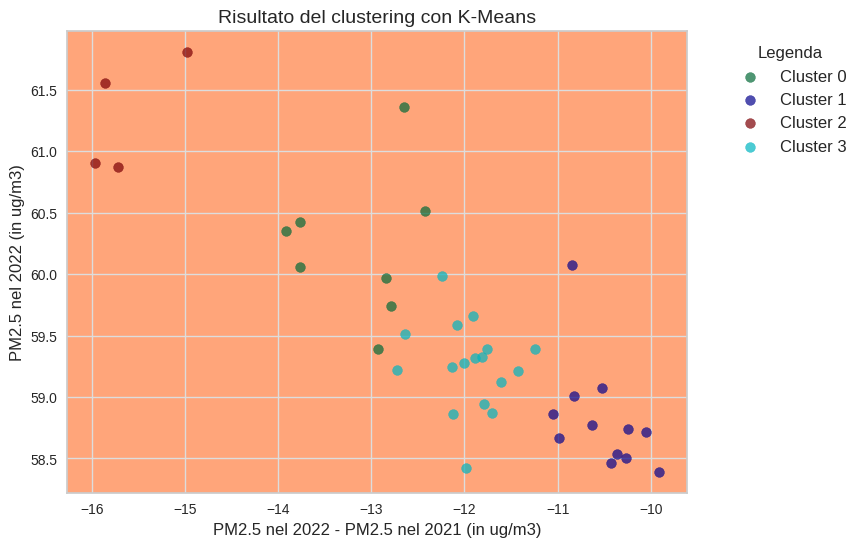

In [ ]:
plot_silhouette(df_clust_pm25, labels, 'PM2.5 nel 2022 - PM2.5 nel 2021 (in ug/m3)', 'PM2.5 nel 2022 (in ug/m3)')

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

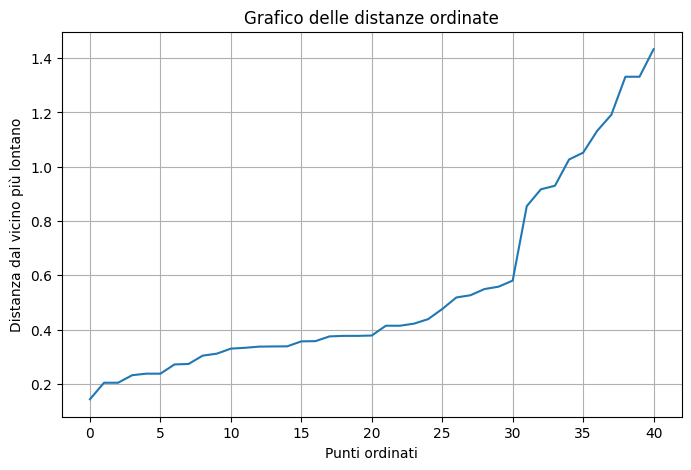

In [ ]:
find_eps(df_clust_pm25, min_samples=4)

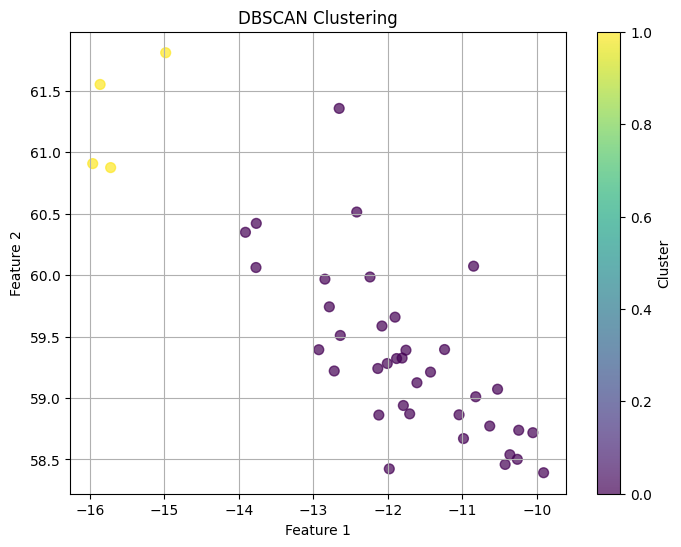

Silhouette Score (DBSCAN): 0.63


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_pm25, eps=1.06, min_samples=4)
plot_clusters(df_clust_pm25, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_pm25, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

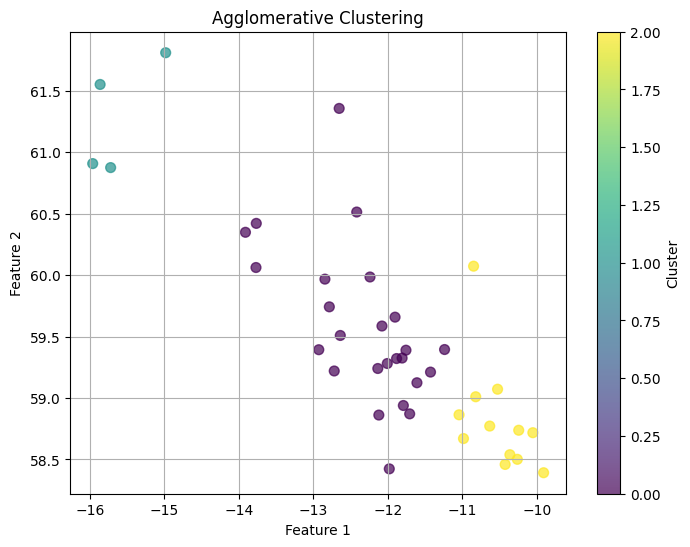

Silhouette Score (Agglomerativo): 0.48


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_pm25, n_clusters=3, linkage_method='complete')
plot_clusters(df_clust_pm25, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_pm25, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

###Visualizzazione del Silhouette Score

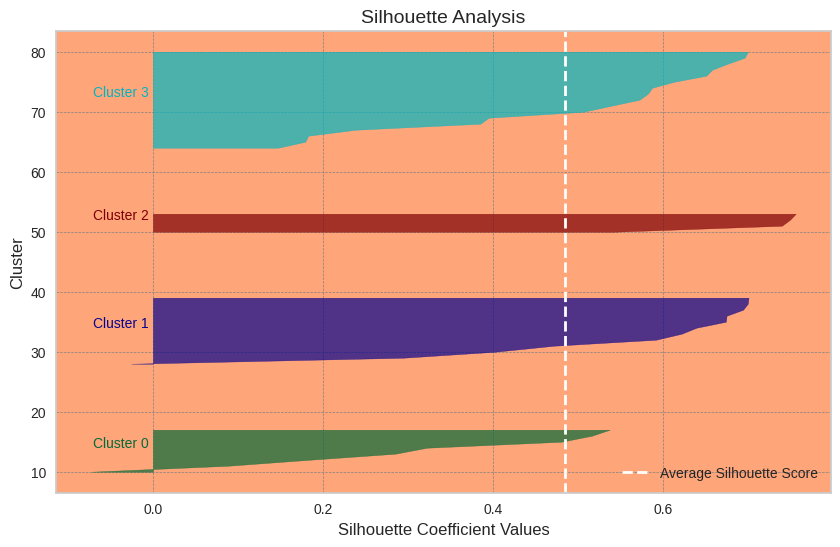

In [ ]:
silhouette_plot(
    df_clust_pm25,
    labels,
    cluster_colors,  # Colori dei cluster
    arancione_sfondo,  # Colore dello sfondo
    grid_color="gray",  # Colore della griglia
    avg_line_color=bianco  # Colore della linea dell'average silhouette score
)

##Clustering PM10

In [ ]:
df_clust_pm10 = result[['PM10 (ug/m3) diff (2022-2021)', 'PM10 (ug/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

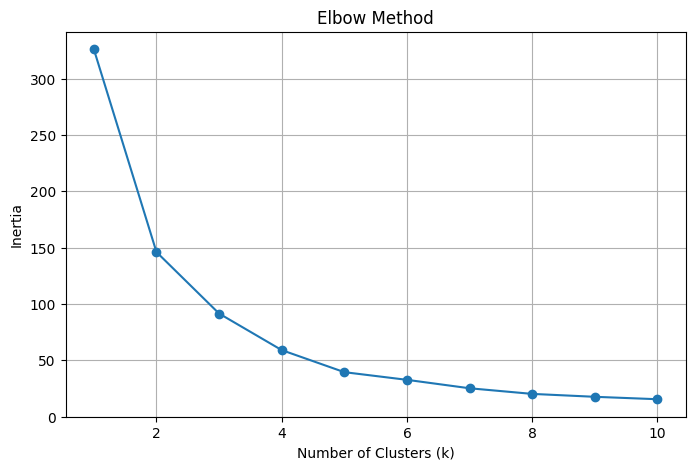

In [ ]:
inertias = elbow_method(df_clust_pm10, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 4
kmeans_model, labels = apply_kmeans(df_clust_pm10, n_clusters=optimal_k)
result['Cluster_pm10'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.46


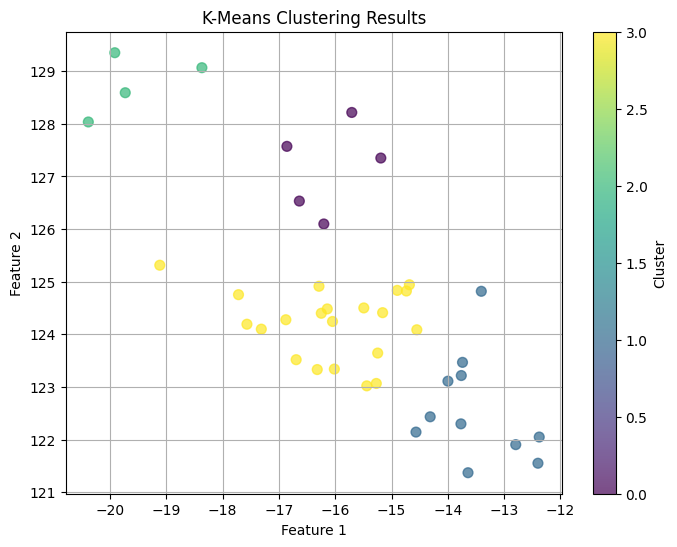

In [ ]:
plot_silhouette(df_clust_pm10, labels)

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

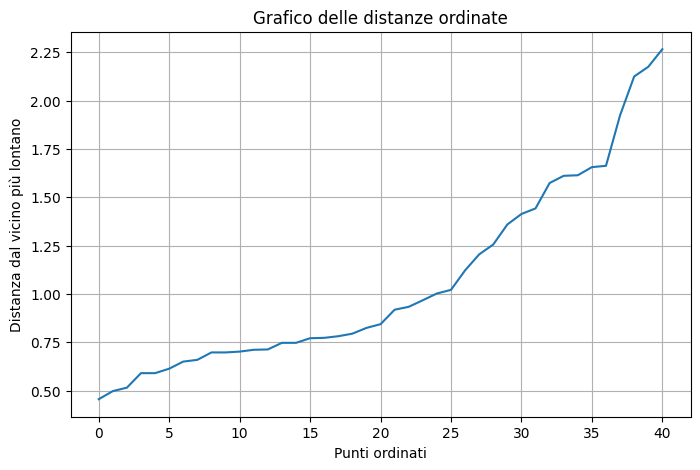

In [ ]:
find_eps(df_clust_pm10, min_samples=4)

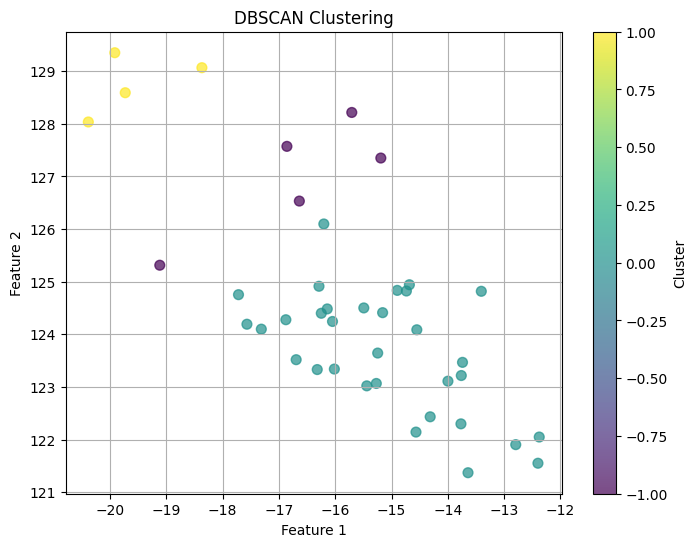

Silhouette Score (DBSCAN): 0.43


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_pm10, eps=1.45, min_samples=4)
plot_clusters(df_clust_pm10, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_pm10, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

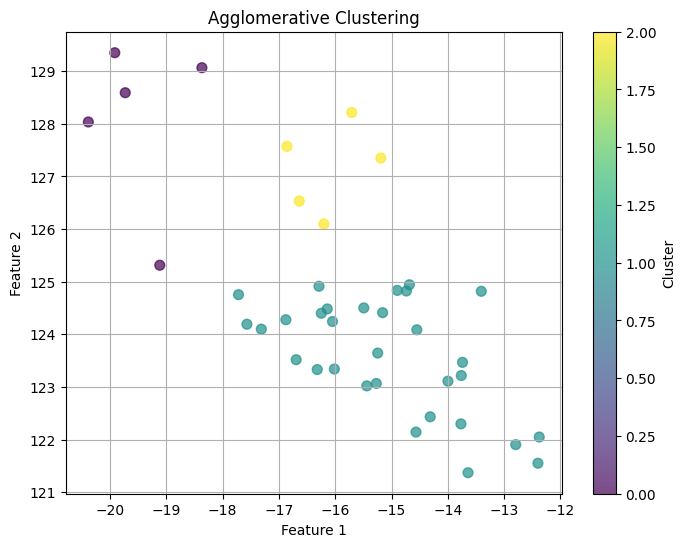

Silhouette Score (Agglomerativo): 0.42


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_pm10, n_clusters=3, linkage_method='average')
plot_clusters(df_clust_pm10, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_pm10, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

Dendogramma

##Clustering NO2

In [ ]:
df_clust_NO2 = result[['NO2 (ug/m3) diff (2022-2021)','NO2 (ug/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

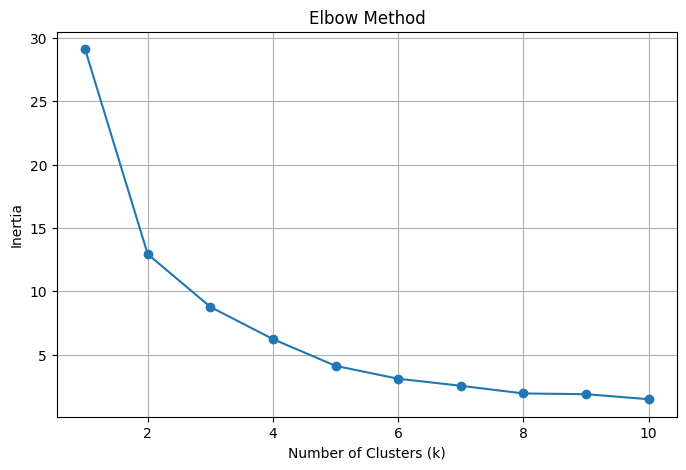

In [ ]:
inertias = elbow_method(df_clust_NO2, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 3
kmeans_model, labels = apply_kmeans(df_clust_NO2, n_clusters=optimal_k)
result['Cluster_NO2'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.45


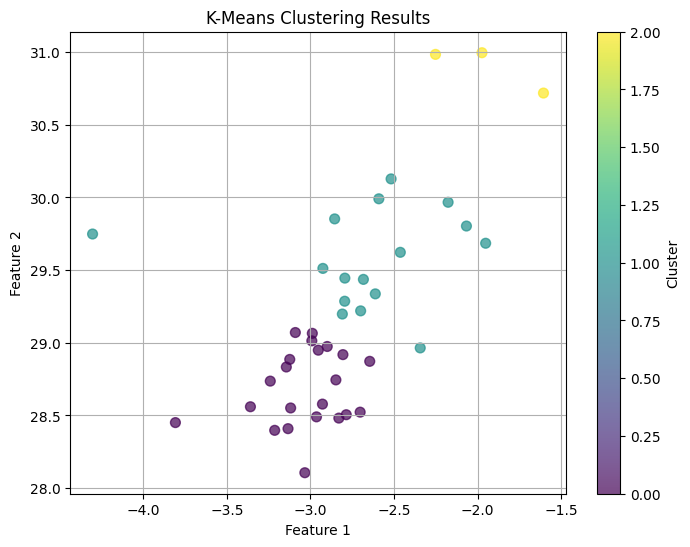

In [ ]:
plot_silhouette(df_clust_NO2, labels)

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

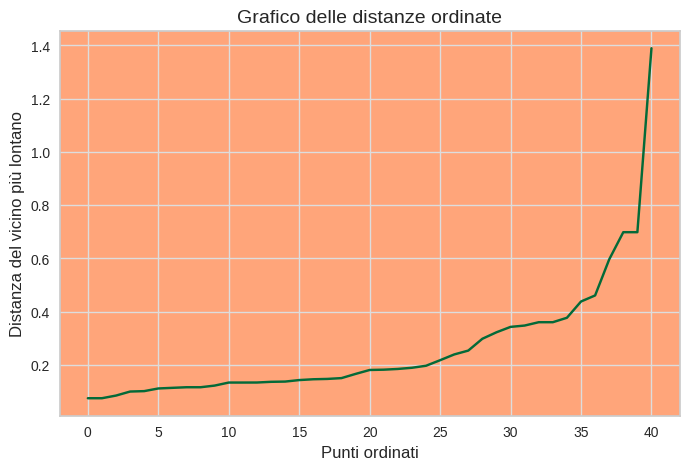

In [ ]:
find_eps(df_clust_NO2, min_samples=3)

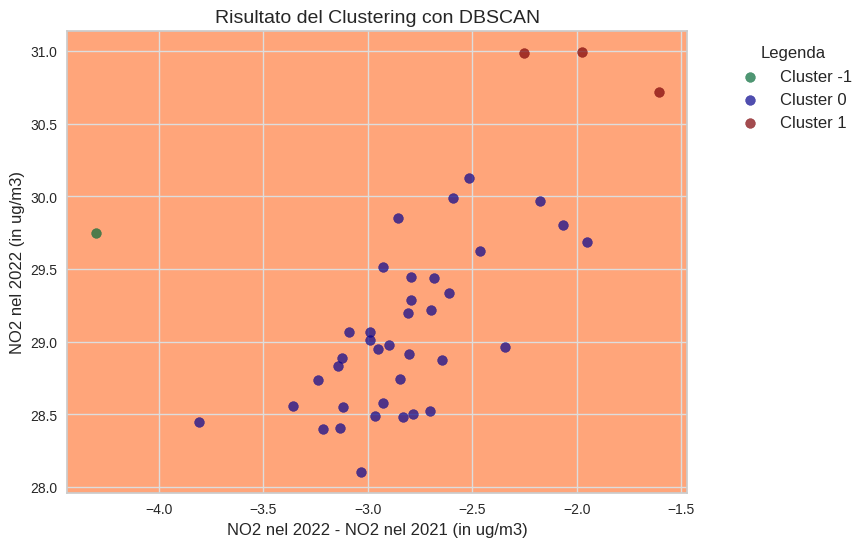

Silhouette Score (DBSCAN): 0.49


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_NO2, eps=0.7, min_samples=3)
plot_clusters(df_clust_NO2, dbscan_labels, title='Risultato del Clustering con DBSCAN', y_label='NO2 nel 2022 (in ug/m3)', x_label='NO2 nel 2022 - NO2 nel 2021 (in ug/m3)')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_NO2, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

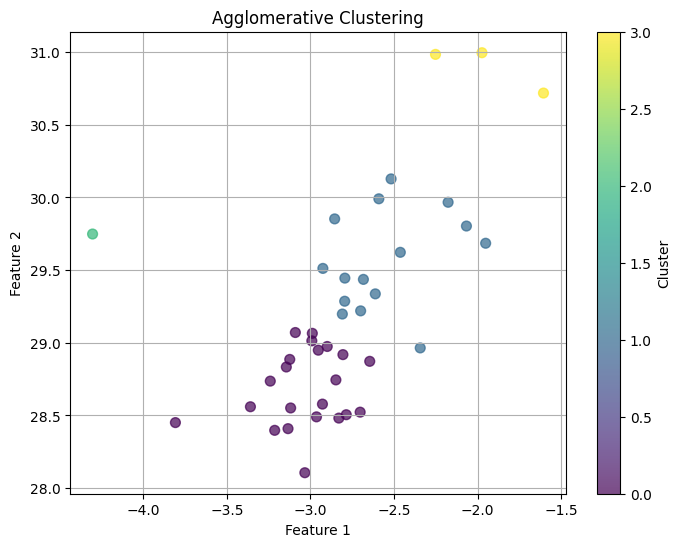

Silhouette Score (Agglomerativo): 0.47


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_NO2, n_clusters=4, linkage_method='average')
plot_clusters(df_clust_NO2, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_NO2, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

Dendogramma

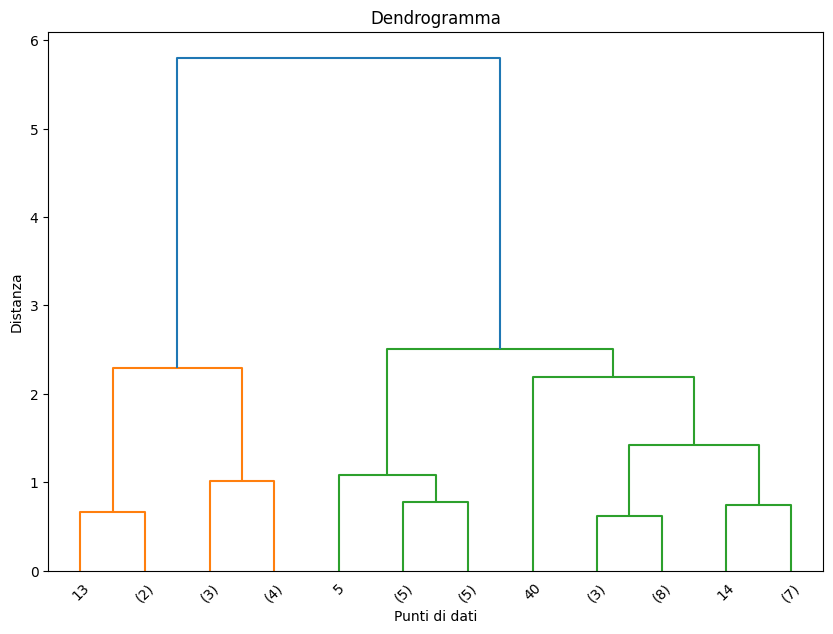

In [ ]:
# Calcolo del linkage e visualizzazione del dendrogramma
linkage_matrix = linkage(df_clust_NO2, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10)
plt.title('Dendrogramma')
plt.xlabel('Punti di dati')
plt.ylabel('Distanza')
plt.show()

###Visualizzazione del Silhouette Score

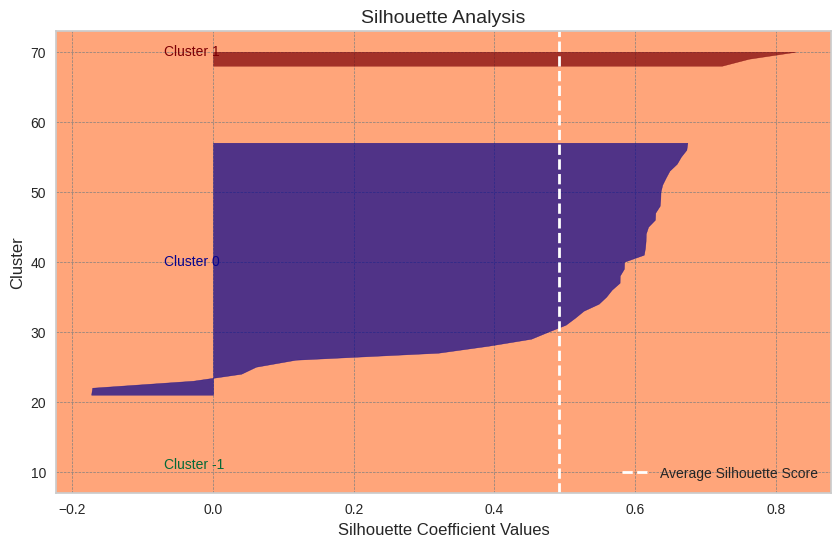

In [ ]:
silhouette_plot(
    df_clust_NO2,
    dbscan_labels,
    cluster_colors,  # Colori dei cluster
    arancione_sfondo,  # Colore dello sfondo
    grid_color="gray",  # Colore della griglia
    avg_line_color=bianco  # Colore della linea dell'average silhouette score
)

## Clustering O3

In [ ]:
df_clust_O3 = result[['Ozone (ug/m3) diff (2022-2021)', 'Ozone (ug/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

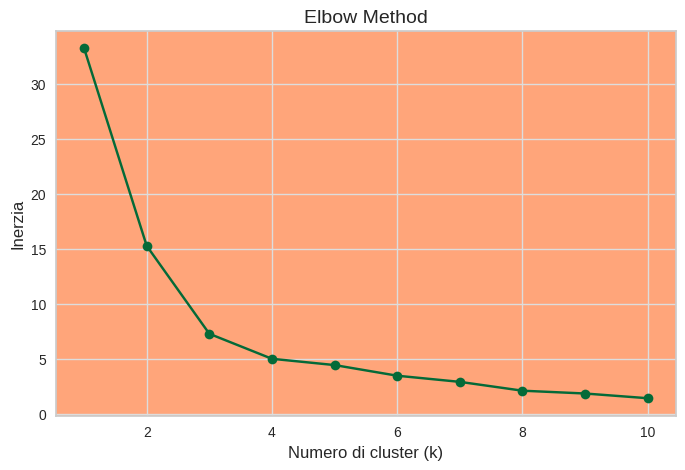

In [ ]:
inertias = elbow_method(df_clust_O3, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 3
kmeans_model, labels = apply_kmeans(df_clust_O3, n_clusters=optimal_k)
result['Cluster_Ozone'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.48


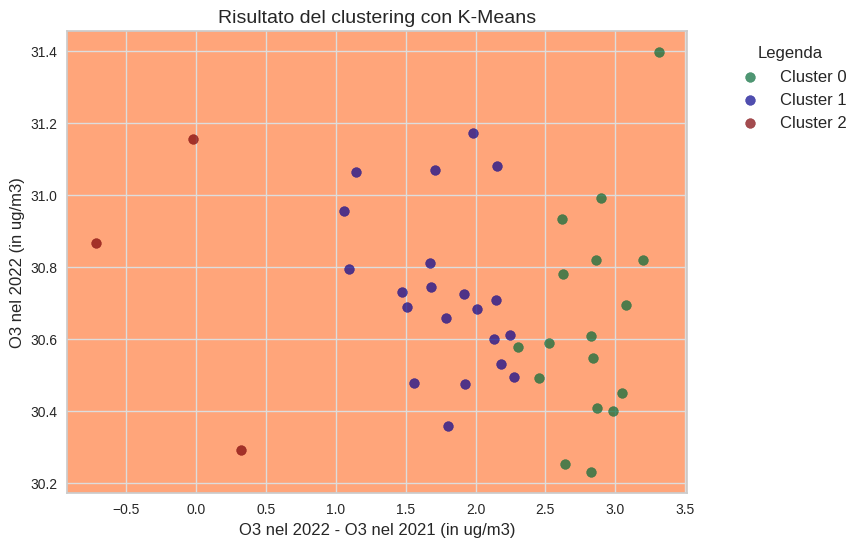

In [ ]:
plot_silhouette(df_clust_O3, labels, y_label='O3 nel 2022 (in ug/m3)', x_label='O3 nel 2022 - O3 nel 2021 (in ug/m3)')

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

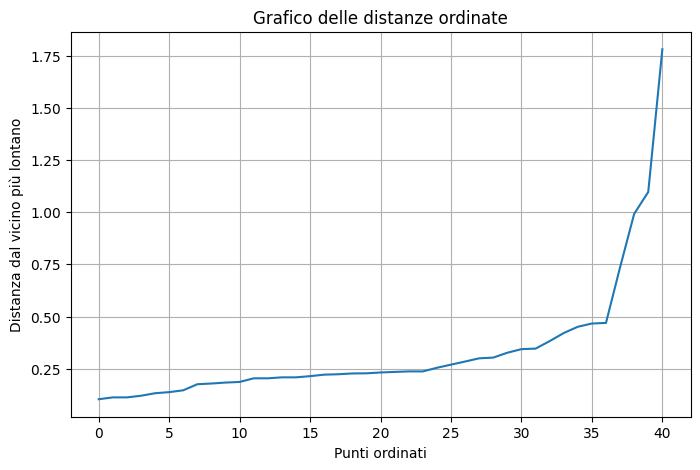

In [ ]:
find_eps(df_clust_O3, min_samples=4)

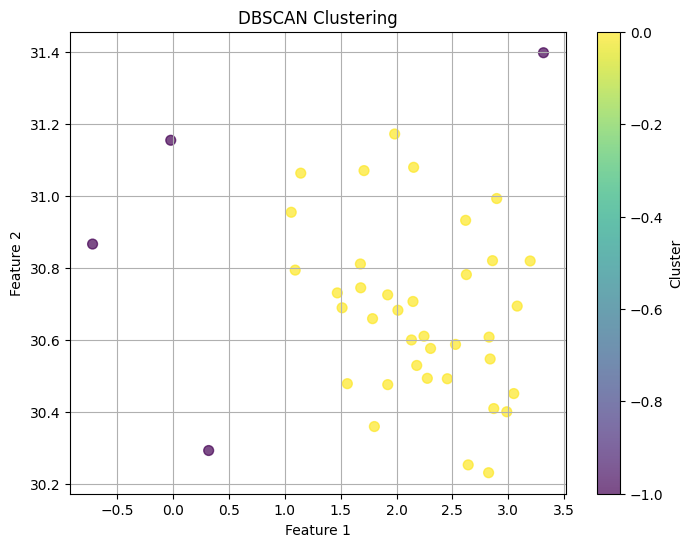

Silhouette Score (DBSCAN): 0.56


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_O3, eps=0.48, min_samples=4)
plot_clusters(df_clust_O3, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_O3, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

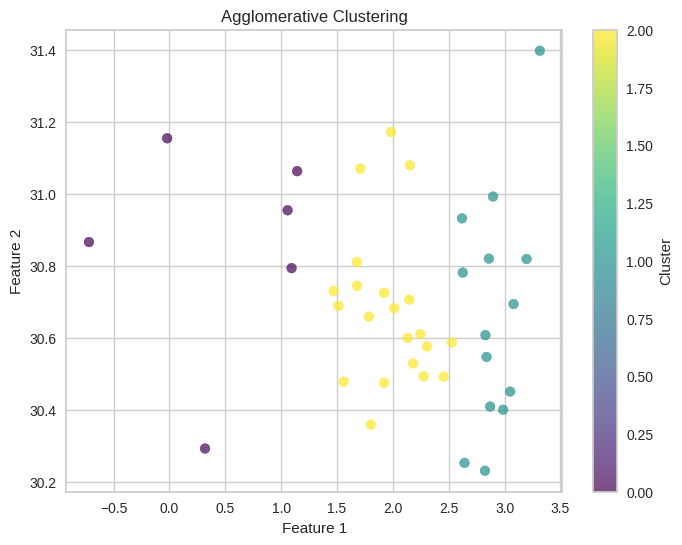

Silhouette Score (Agglomerativo): 0.45


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_O3, n_clusters=3, linkage_method='complete')
plot_clusters(df_clust_O3, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_O3, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

###Visualizzazione del Silhouette Score

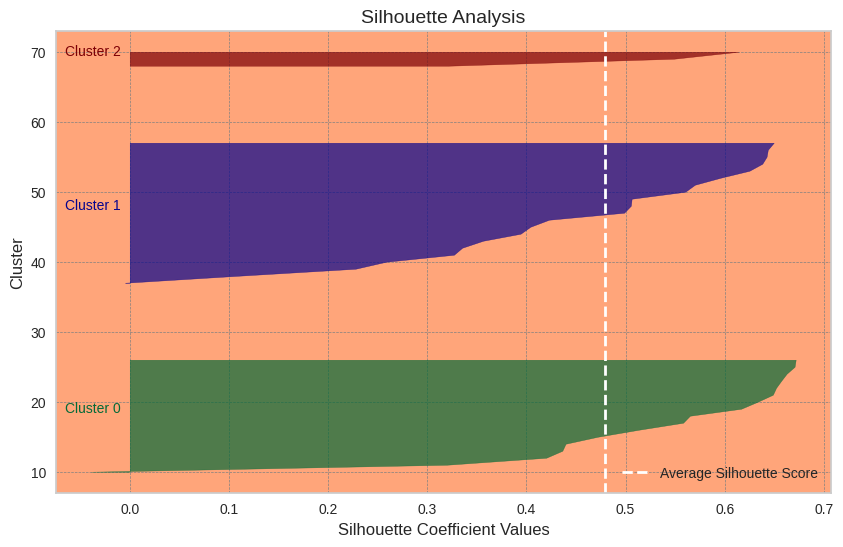

In [ ]:
silhouette_plot(
    df_clust_O3,
    labels,
    cluster_colors,  # Colori dei cluster
    arancione_sfondo,  # Colore dello sfondo
    grid_color="gray",  # Colore della griglia
    avg_line_color=bianco  # Colore della linea dell'average silhouette score
)

## Clustering CO

In [ ]:
df_clust_CO = result[['CO (mg/m3) diff (2022-2021)', 'CO (mg/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

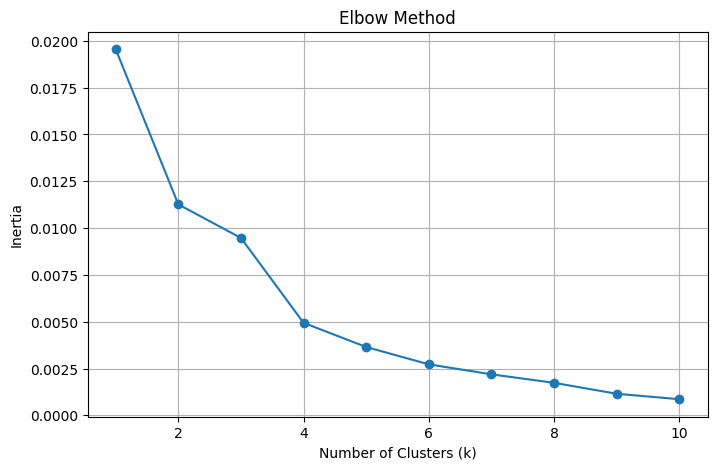

In [ ]:
inertias = elbow_method(df_clust_CO, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 5
kmeans_model, labels = apply_kmeans(df_clust_CO, n_clusters=optimal_k)
result['Cluster_CO'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.45


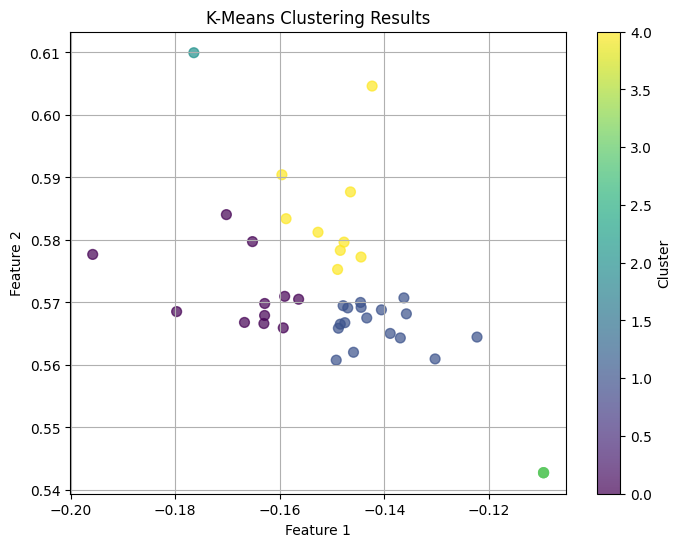

In [ ]:
plot_silhouette(df_clust_CO, labels)

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

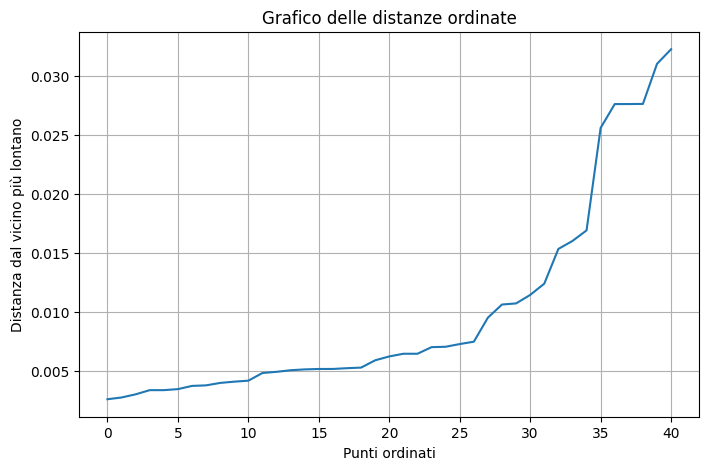

In [ ]:
find_eps(df_clust_CO, min_samples=5)

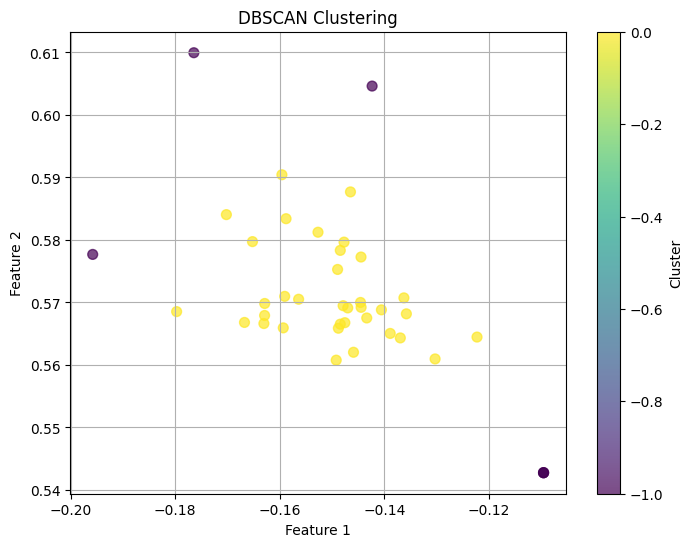

Silhouette Score (DBSCAN): 0.51


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_CO, eps=0.017, min_samples=5)
plot_clusters(df_clust_CO, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_CO, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

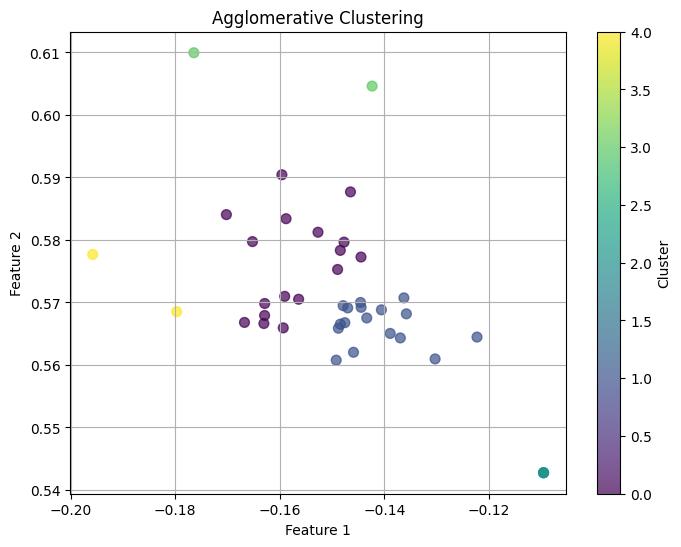

Silhouette Score (Agglomerativo): 0.41


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_CO, n_clusters=4, linkage_method='ward')
plot_clusters(df_clust_CO, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_CO, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

Dendogramma

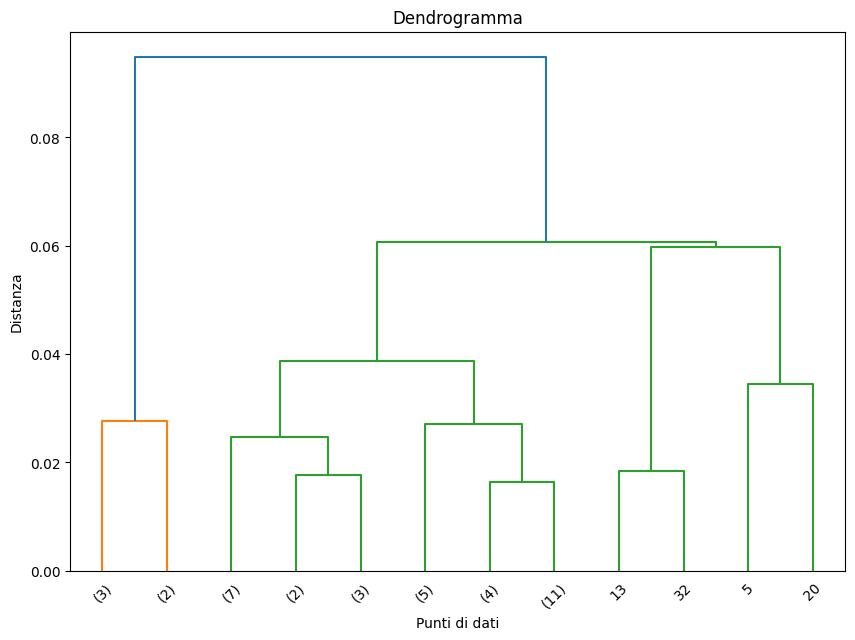

In [ ]:
# Calcolo del linkage e visualizzazione del dendrogramma
linkage_matrix = linkage(df_clust_CO, method='complete')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10)
plt.title('Dendrogramma')
plt.xlabel('Punti di dati')
plt.ylabel('Distanza')
plt.show()

## Clustering NO

In [ ]:
df_clust_NO = result[['NO (ug/m3) diff (2022-2021)', 'NO (ug/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

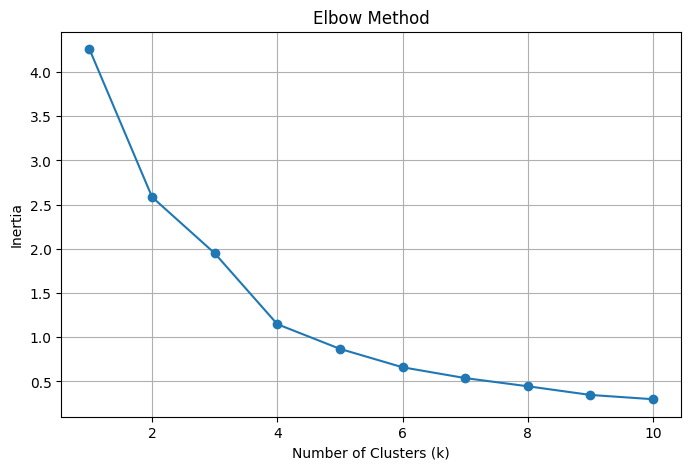

In [ ]:
inertias = elbow_method(df_clust_NO, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 4
kmeans_model, labels = apply_kmeans(df_clust_NO, n_clusters=optimal_k)
result['Cluster_NO'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.43


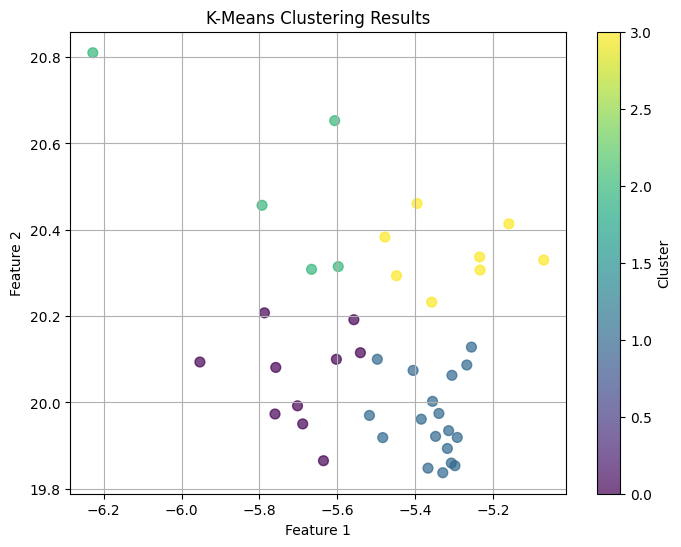

In [ ]:
plot_silhouette(df_clust_NO, labels)

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

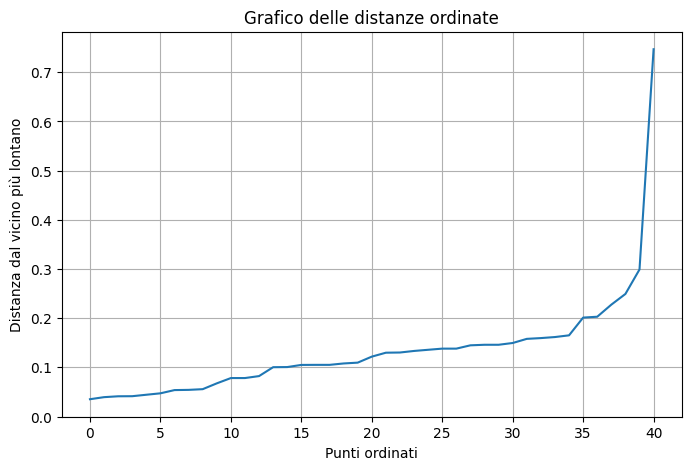

In [ ]:
find_eps(df_clust_NO, min_samples=4)

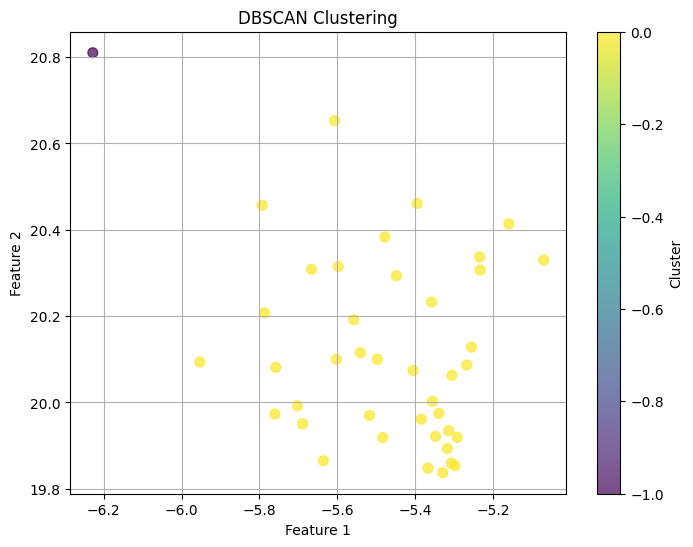

Silhouette Score (DBSCAN): 0.62


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_NO, eps=0.3, min_samples=4)
plot_clusters(df_clust_NO, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_NO, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

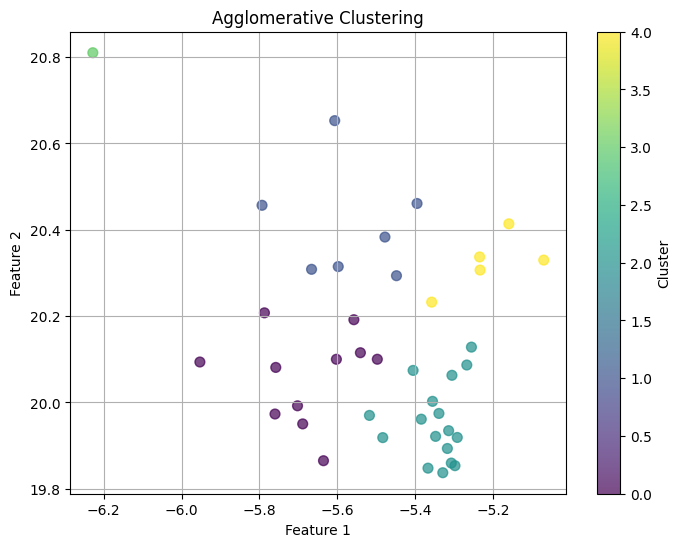

Silhouette Score (Agglomerativo): 0.42


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_NO, n_clusters=5, linkage_method='ward')
plot_clusters(df_clust_NO, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_NO, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

Dendogramma

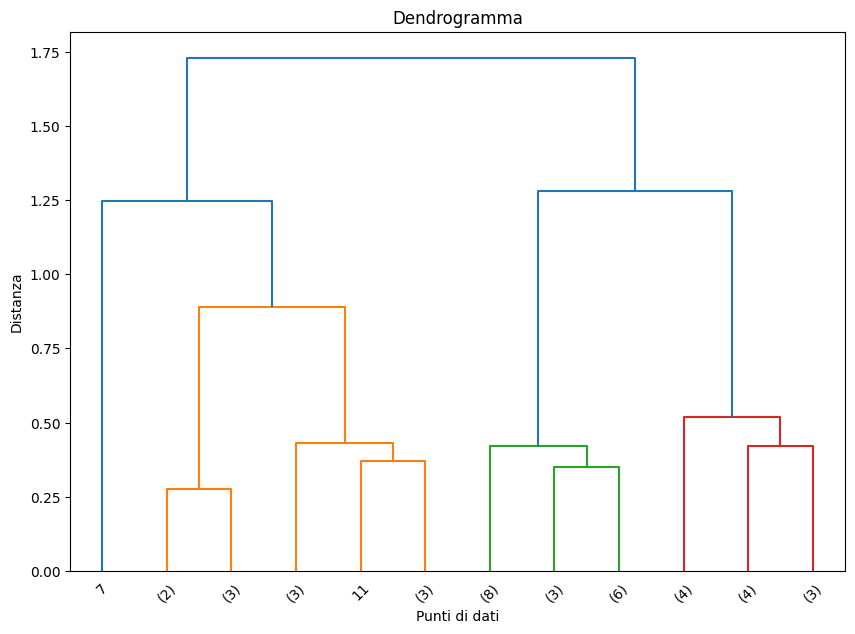

In [ ]:
# Calcolo del linkage e visualizzazione del dendrogramma
linkage_matrix = linkage(df_clust_NO, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10)
plt.title('Dendrogramma')
plt.xlabel('Punti di dati')
plt.ylabel('Distanza')
plt.show()

## Clustering SO2

In [ ]:
df_clust_SO2 = result[['SO2 (ug/m3) diff (2022-2021)', 'SO2 (ug/m3) (2022)']]

###K-Means

Applicazione dell'Elbow Method

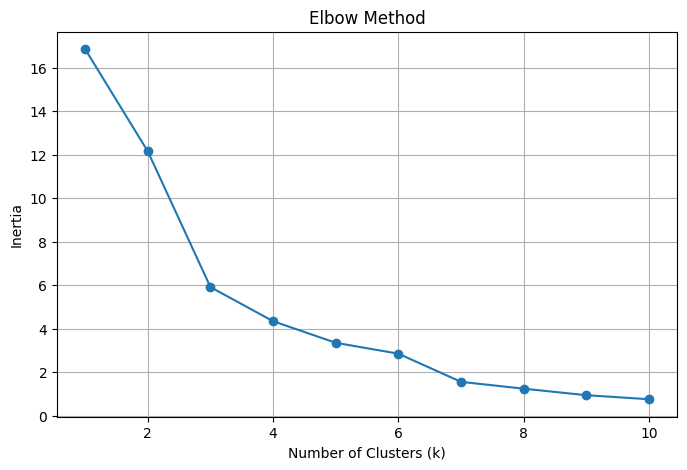

In [ ]:
inertias = elbow_method(df_clust_SO2, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 4
kmeans_model, labels = apply_kmeans(df_clust_SO2, n_clusters=optimal_k)
result['Cluster_SO2'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.46


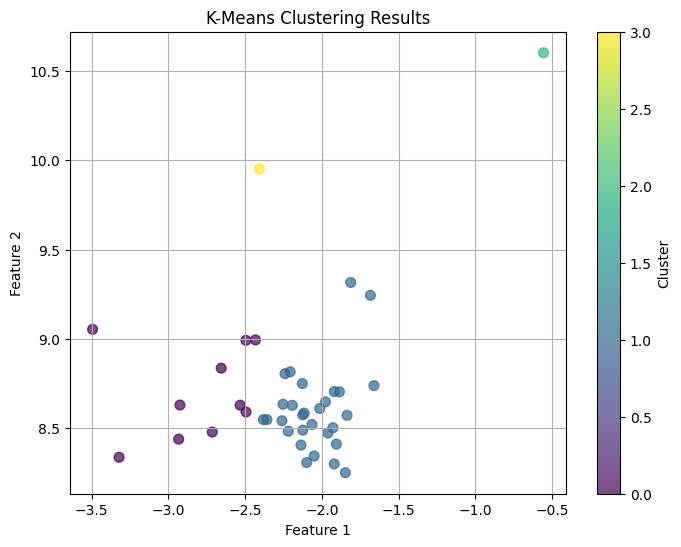

In [ ]:
plot_silhouette(df_clust_SO2, labels)

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

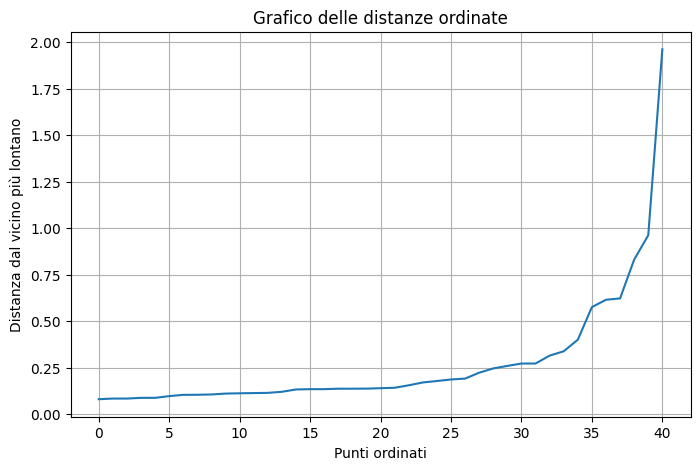

In [ ]:
find_eps(df_clust_SO2, min_samples=4)

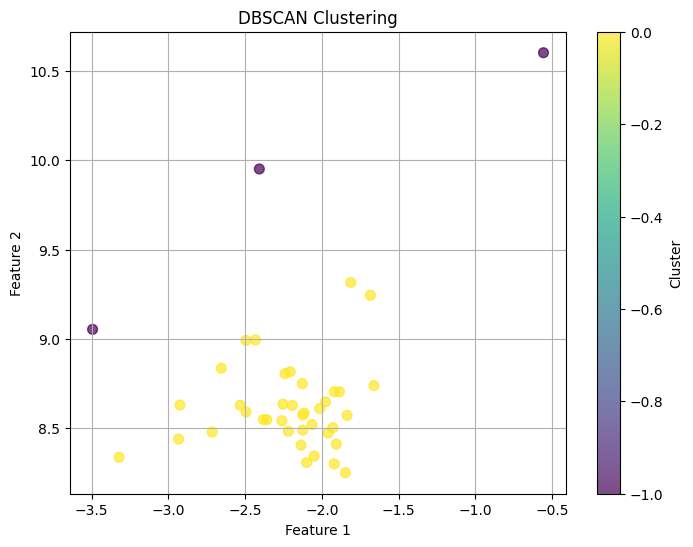

Silhouette Score (DBSCAN): 0.64


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_clust_SO2, eps=0.62, min_samples=4)
plot_clusters(df_clust_SO2, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_clust_SO2, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

###Clustering gerarchico

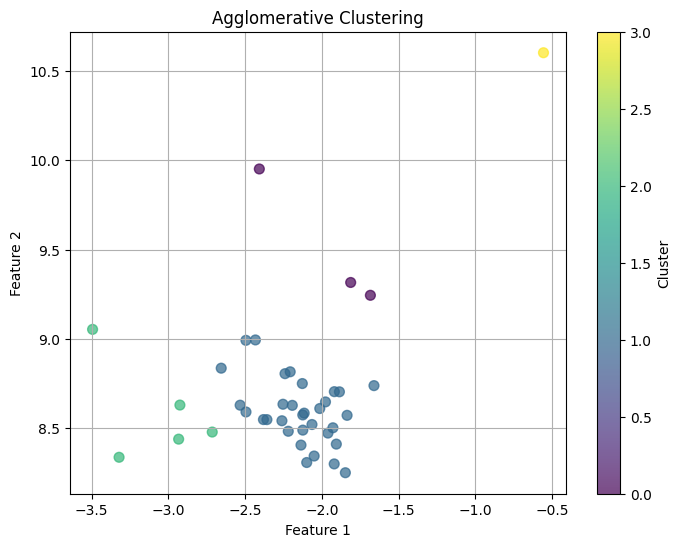

Silhouette Score (Agglomerativo): 0.52


In [ ]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_clust_SO2, n_clusters=4, linkage_method='complete')
plot_clusters(df_clust_SO2, agg_labels, title='Agglomerative Clustering')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_clust_SO2, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')

Dendogramma

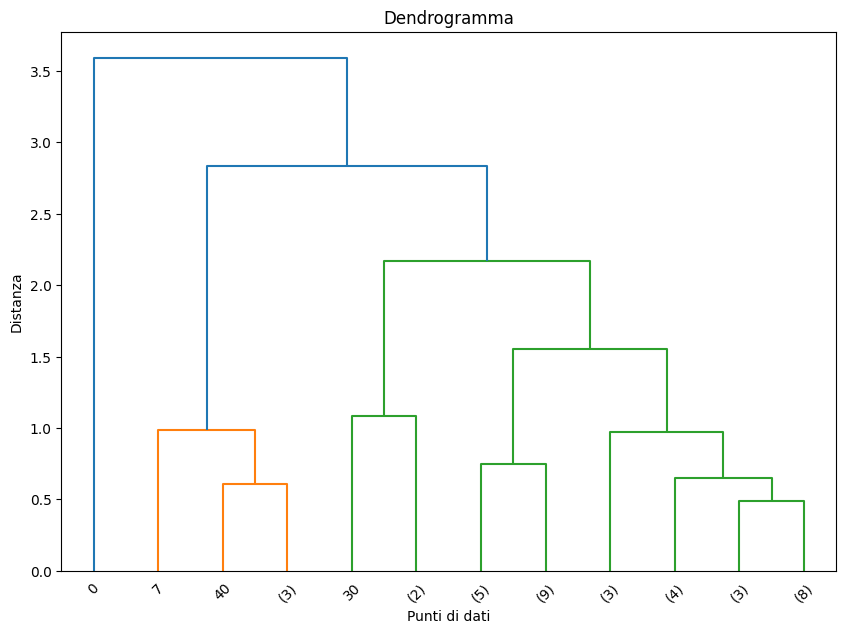

In [ ]:
# Calcolo del linkage e visualizzazione del dendrogramma
linkage_matrix = linkage(df_clust_SO2, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10)
plt.title('Dendrogramma')
plt.xlabel('Punti di dati')
plt.ylabel('Distanza')
plt.show()

##Clustering concentrazione media delle sostanze nel 2022

###Preprocessing

Correlazioni per scartare sostanze a priori

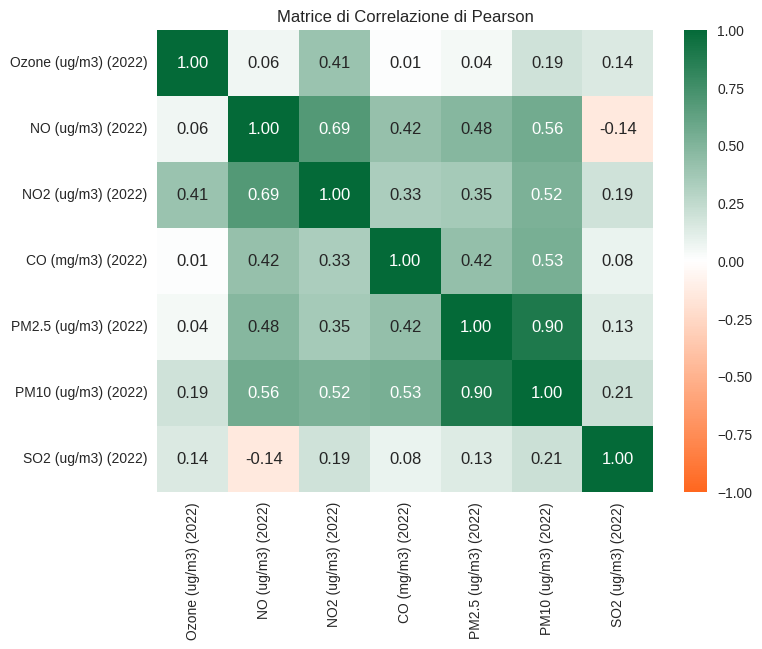

In [15]:
# Selezione delle colonne per il calcolo della correlazione
colonne_da_correlare = ['Ozone (ug/m3) (2022)', 'NO (ug/m3) (2022)',
       'NO2 (ug/m3) (2022)', 'CO (mg/m3) (2022)', 'PM2.5 (ug/m3) (2022)',
       'PM10 (ug/m3) (2022)', 'SO2 (ug/m3) (2022)']

mostra_heatmap_correlazione(result, colonne_da_correlare, 'pearson', 'Matrice di Correlazione di Pearson')

Si può non considerare la feature "PM2.5 (ug/m3) (2022)", in quanto quasi perfettamente correlata con "PM10 (ug/m3) (2022)".

PCA

In [16]:
# Normalizzazione dei dati
scaler = StandardScaler()
df_sostanze_2022_normalizzato = scaler.fit_transform(df_sostanze_aggregato_2022[['Ozone (ug/m3) (2022)', 'NO (ug/m3) (2022)',
                                                                                  'NO2 (ug/m3) (2022)', 'CO (mg/m3) (2022)',
                                                                                  'PM10 (ug/m3) (2022)', 'SO2 (ug/m3) (2022)']])
# Applicazione della PCA per ridurre a 2 dimensioni
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_sostanze_2022_normalizzato)

df_sostanze_2022_bidimensionale = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])

print(df_sostanze_2022_bidimensionale.head())

       PCA1      PCA2
0 -1.199773  2.358578
1 -0.480951  0.080252
2 -2.229731  0.354087
3  0.578611  0.388940
4  0.569833 -0.472010


###K-Means

Applicazione dell'Elbow Method

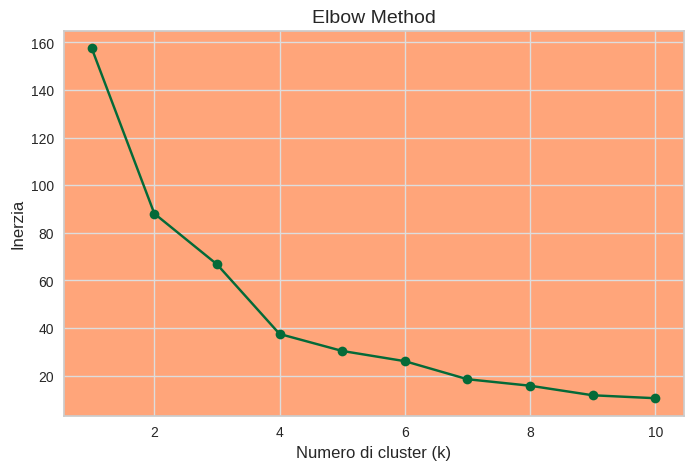

In [ ]:
inertias = elbow_method(df_sostanze_2022_bidimensionale, max_k=10)

Applicazione di K-Means

In [ ]:
optimal_k = 4
kmeans_model, labels = apply_kmeans(df_sostanze_2022_bidimensionale, n_clusters=optimal_k)
df_sostanze_2022_bidimensionale['Cluster'] = labels

Valutazione del Silhouette Score

Silhouette Score: 0.56


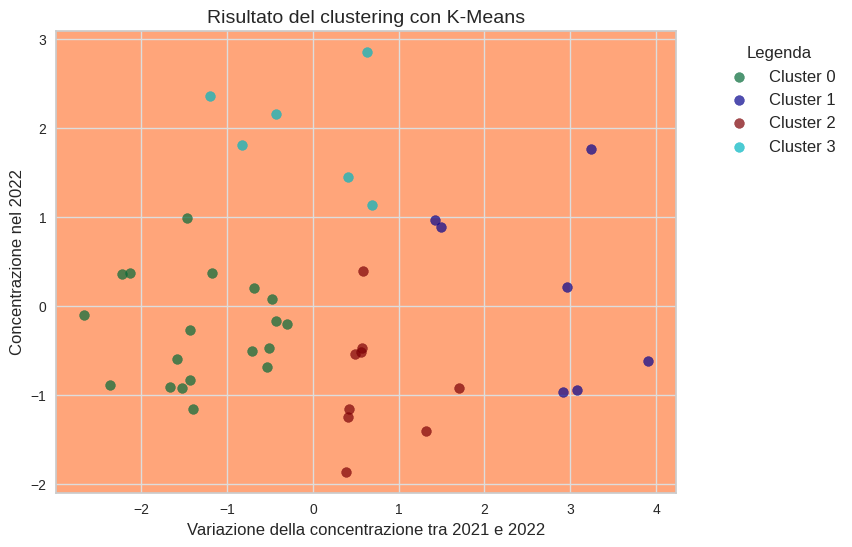

In [ ]:
plot_silhouette(df_sostanze_2022_bidimensionale, labels)

###DBSCAN

Plotting delle distanze tra punti per trovare il valore per il parametro EPS

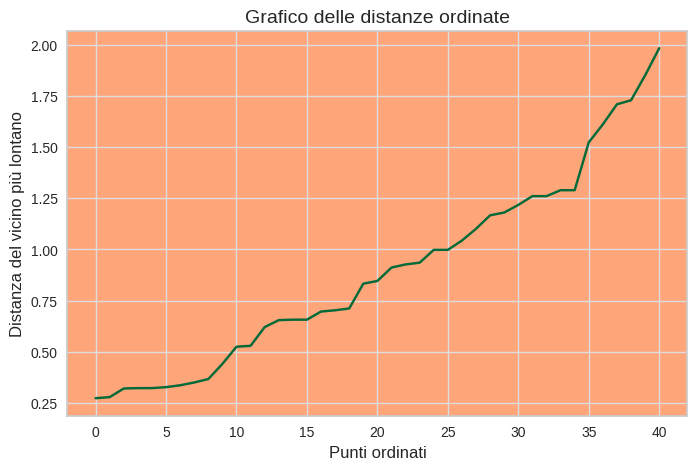

In [ ]:
find_eps(df_sostanze_2022_bidimensionale, min_samples=4)

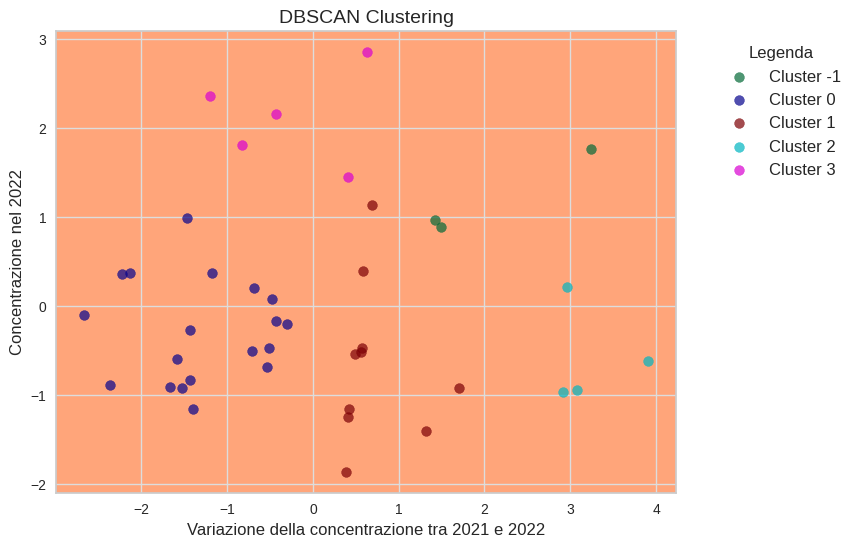

Silhouette Score (DBSCAN): 0.55


In [ ]:
# Applicazione di DBSCAN
dbscan_model, dbscan_labels = apply_dbscan(df_sostanze_2022_bidimensionale, eps=1.27, min_samples=4)
plot_clusters(df_sostanze_2022_bidimensionale, dbscan_labels, title='DBSCAN Clustering')
# Calcolo della silhouette score per DBSCAN
dbscan_silhouette = silhouette_score(df_sostanze_2022_bidimensionale, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
if dbscan_silhouette:
    print(f'Silhouette Score (DBSCAN): {dbscan_silhouette:.2f}')
else:
    print('Silhouette Score (DBSCAN) non calcolabile: meno di 2 cluster rilevati.')

df_sostanze_2022_bidimensionale['Cluster'] = dbscan_labels

###Clustering gerarchico

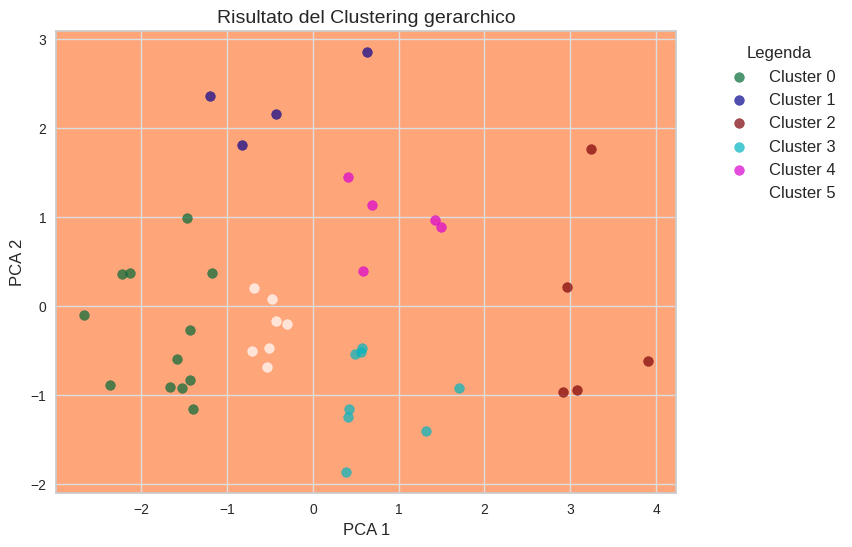

Silhouette Score (Agglomerativo): 0.41


In [17]:
# Applicazione di clustering agglomerativo
agg_model, agg_labels = apply_agglomerative(df_sostanze_2022_bidimensionale, n_clusters=6, linkage_method='ward')
plot_clusters(df_sostanze_2022_bidimensionale, agg_labels, 'Risultato del Clustering gerarchico', 'PCA 1', 'PCA 2')
# Calcolo della silhouette score per clustering agglomerativo
agg_silhouette = silhouette_score(df_sostanze_2022_bidimensionale, agg_labels)
print(f'Silhouette Score (Agglomerativo): {agg_silhouette:.2f}')
df_sostanze_2022_bidimensionale['Cluster'] = agg_labels

###Visualizzazione del Silhouette Score

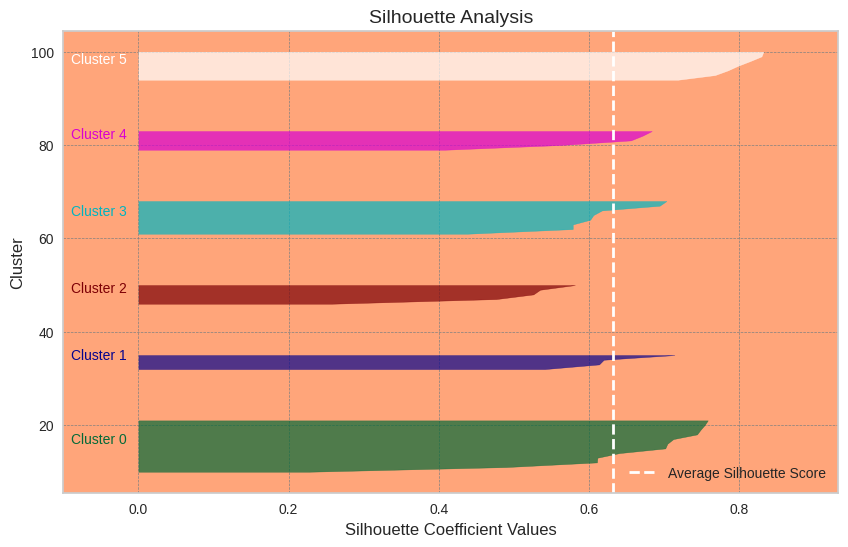

In [18]:
silhouette_plot(
    df_sostanze_2022_bidimensionale,
    agg_labels,
    cluster_colors,  # Colori dei cluster
    arancione_sfondo,  # Colore dello sfondo
    grid_color="gray",  # Colore della griglia
    avg_line_color=bianco  # Colore della linea dell'average silhouette score
)

###Interpretazione dei cluster

In [19]:
df_sostanze_aggregato_2022['Cluster'] = df_sostanze_2022_bidimensionale['Cluster'].values

<ipython-input-28-ebde4f3f7b43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


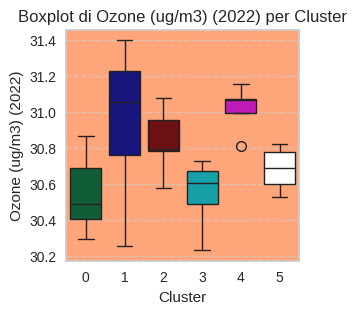

<ipython-input-28-ebde4f3f7b43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


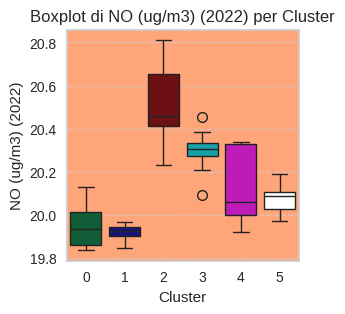

<ipython-input-28-ebde4f3f7b43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


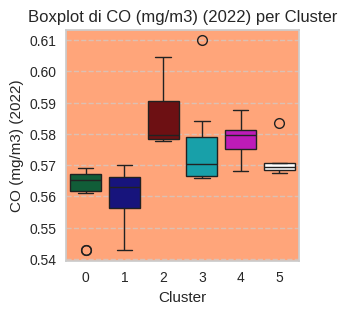

<ipython-input-28-ebde4f3f7b43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


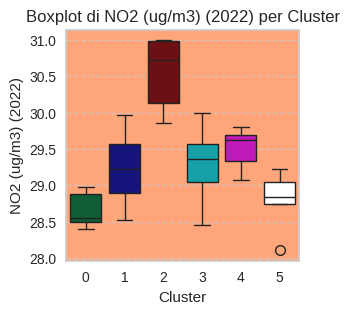

<ipython-input-28-ebde4f3f7b43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


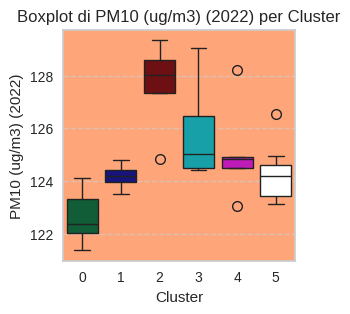

<ipython-input-28-ebde4f3f7b43>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


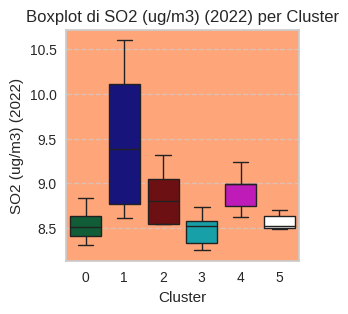

In [ ]:
substances = ['Ozone (ug/m3) (2022)', 'NO (ug/m3) (2022)', 'CO (mg/m3) (2022)',
              'NO2 (ug/m3) (2022)', 'PM10 (ug/m3) (2022)', 'SO2 (ug/m3) (2022)']

# Creazione dei boxplot con colori specifici per ogni Cluster
for substance in substances:
    plt.figure(figsize=(3, 3))

    # Creazione del boxplot con colori per Cluster
    ax = sns.boxplot(
        data=df_sostanze_aggregato_2022,
        x='Cluster',
        y=substance,
        palette = {'0': verde, '1': blu, '2': bordeaux, '3': '#00b5c1', '4': '#d900d1', '5': bianco},
        medianprops={'color': '#222222'},  # Colore della mediana
        whiskerprops={'color': '#222222'},  # Colore dei whisker
        capprops={'color': '#222222'}  # Colore dei cap
    )

    # Impostazione del colore dello sfondo
    ax.set_facecolor(arancione_sfondo)

    # Titoli e etichette
    plt.title(f'Boxplot di {substance} per Cluster', fontsize=12)
    plt.xlabel('Cluster', fontsize=11)
    plt.ylabel(substance, fontsize=11)

    # Aggiunta griglia
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostra il plot
    plt.show()


<ipython-input-30-a4e0563a39d4>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


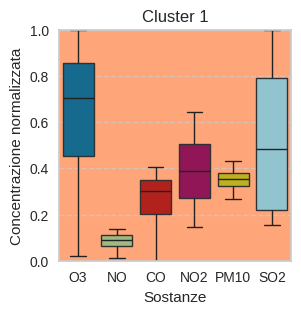

<ipython-input-30-a4e0563a39d4>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


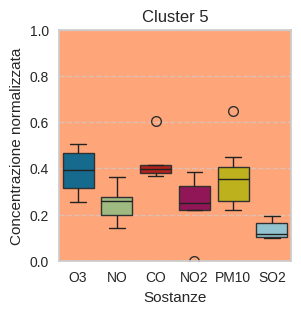

<ipython-input-30-a4e0563a39d4>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


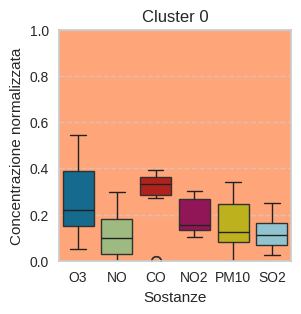

<ipython-input-30-a4e0563a39d4>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


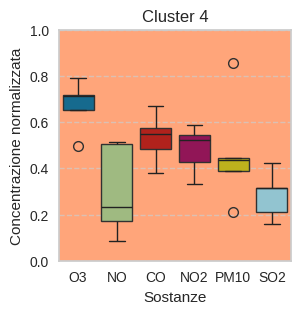

<ipython-input-30-a4e0563a39d4>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


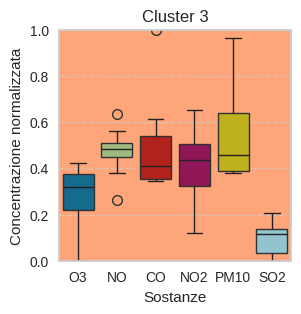

<ipython-input-30-a4e0563a39d4>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


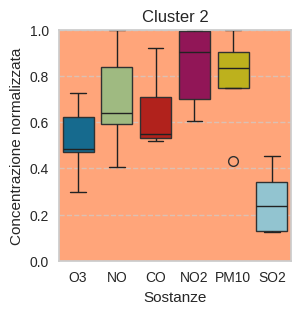

In [30]:
substances = ['Ozone (ug/m3) (2022)', 'NO (ug/m3) (2022)', 'CO (mg/m3) (2022)',
              'NO2 (ug/m3) (2022)', 'PM10 (ug/m3) (2022)', 'SO2 (ug/m3) (2022)']

# Definizione della palette colori per ogni cluster
palette_substances = {'O3': '#0272a2', 'NO': '#9fc377', 'CO': '#ca0b03',
                      'NO2': '#a50258', 'PM10': '#d7c703', 'SO2': '#88cada'}

# Mappatura dei nomi delle sostanze a etichette più leggibili
substance_labels = {
    'Ozone (ug/m3) (2022)': 'O3',
    'NO (ug/m3) (2022)': 'NO',
    'CO (mg/m3) (2022)': 'CO',
    'NO2 (ug/m3) (2022)': 'NO2',
    'PM10 (ug/m3) (2022)': 'PM10',
    'SO2 (ug/m3) (2022)': 'SO2'
}

# Copia del dataframe per evitare modifiche ai dati originali
df_normalized = df_sostanze_aggregato_2022.copy()

# Normalizzazione delle sostanze
for substance in substances:
    min_val = df_normalized[substance].min()
    max_val = df_normalized[substance].max()
    df_normalized[substance] = (df_normalized[substance] - min_val) / (max_val - min_val)

# Creazione dei boxplot per ogni Cluster
clusters = df_normalized['Cluster'].unique()

for cluster in clusters:
    plt.figure(figsize=(3, 3))

    # Filtra i dati per il cluster corrente
    df_cluster = df_normalized[df_normalized['Cluster'] == cluster]

    # Ristrutturazione del dataframe in formato long
    df_melted = df_cluster.melt(id_vars=['Cluster'], value_vars=substances, var_name='Sostanza', value_name='Valore')
    df_melted['Sostanza'] = df_melted['Sostanza'].replace(substance_labels)  # Rinomina le colonne

    # Creazione del boxplot con le diverse sostanze normalizzate
    ax = sns.boxplot(
        data=df_melted,
        x='Sostanza',
        y='Valore',
        palette=palette_substances,
        medianprops={'color': '#222222'},
        whiskerprops={'color': '#222222'},
        capprops={'color': '#222222'}
    )

    # Impostazione dello sfondo e dei titoli
    ax.set_facecolor(arancione_sfondo)
    plt.title(f'Cluster {cluster}', fontsize=12)
    plt.xlabel('Sostanze', fontsize=11)
    plt.ylabel('Concentrazione normalizzata', fontsize=11)

    # Impostazione della scala dell'asse Y tra 0 e 1
    plt.ylim(0, 1)

    # Rotazione delle etichette per migliorare leggibilità
    plt.xticks(rotation=0)

    # Aggiunta griglia
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostra il plot
    plt.show()

In [ ]:
# Raggruppamento per cluster e calcolo delle medie
cluster_means = df_sostanze_aggregato_2022.groupby('Cluster').mean()

print("Medie delle variabili per ciascun cluster:")
print(cluster_means)

# Selezione delle variabili da normalizzare
substances = ['Ozone (ug/m3) (2022)', 'NO (ug/m3) (2022)', 'CO (mg/m3) (2022)',
              'NO2 (ug/m3) (2022)', 'PM10 (ug/m3) (2022)', 'SO2 (ug/m3) (2022)']

# Calcolo delle medie per ciascun cluster
cluster_means = df_sostanze_aggregato_2022[substances + ['Cluster']].groupby('Cluster').mean()

# Calcolo del valore minimo e massimo dell'intero dataset (non sulle medie per cluster)
global_min = df_sostanze_aggregato_2022[substances].min()
global_max = df_sostanze_aggregato_2022[substances].max()

# Normalizzazione rispetto ai valori minimi e massimi dell'intero dataset
cluster_means_normalized = (cluster_means - global_min) / (global_max - global_min)

print("Medie normalizzate rispetto ai valori globali:")
print(cluster_means_normalized)


Medie delle variabili per ciascun cluster:
         Ozone (ug/m3) (2022)  NO (ug/m3) (2022)  NO2 (ug/m3) (2022)  \
Cluster                                                                
0                   30.535797          19.952751           28.640867   
1                   30.939221          19.917645           29.235004   
2                   30.837722          20.514123           30.536055   
3                   30.563357          20.295601           29.308037   
4                   31.018798          20.130717           29.503826   
5                   30.684106          20.074605           28.817801   

         CO (mg/m3) (2022)  PM2.5 (ug/m3) (2022)  PM10 (ug/m3) (2022)  \
Cluster                                                                 
0                 0.561969             58.767754           122.583486   
1                 0.559644             59.384748           124.174389   
2                 0.586164             60.462813           127.628954   
3              

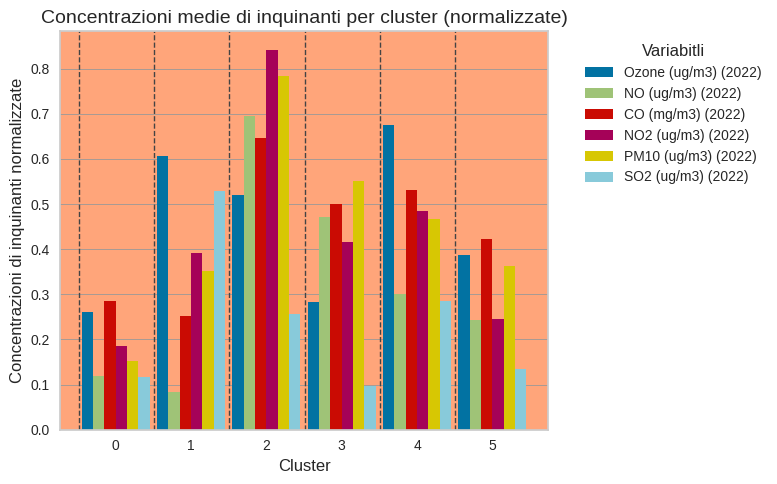

In [ ]:
# Trasposizione del dataframe normalizzato per scambiare campi e cluster
cluster_means_transposed = cluster_means_normalized.T

# Preparazione dei dati
clusters = cluster_means_transposed.columns
variables = cluster_means_transposed.index
x = np.arange(len(clusters))                # Posizioni dei cluster sull'asse x
width = 0.15                                # Larghezza delle barre

# Preparazione del grafico con griglia verticale per i cluster
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.set_facecolor(arancione_sfondo)                                # Sfondo del grafico
ax.grid(color="#999999", linestyle='-', linewidth=0.6, axis='y')  # Griglia orizzontale
ax.grid(visible = None, axis='x')

# Creazione delle barre per ciascun campo
for i, field in enumerate(variables):
    plt.bar(x + i * width, cluster_means_transposed.loc[field], width, label=field)

# Aggiunta delle linee verticali per separare i cluster
for cluster_position in x:
    plt.axvline(x=cluster_position - 0.115, color="#444444", linestyle='--', linewidth=1)  # Linea verticale

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Concentrazioni di inquinanti normalizzate', fontsize=12)
plt.title('Concentrazioni medie di inquinanti per cluster (normalizzate)', fontsize=14)
plt.xticks(x + (width * (len(variables) - 1)) / 2, clusters)                    # Centra i cluster
plt.legend(title="Variabitli", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()